###  Mount Google drive


In [44]:
'''
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/gdrive/')
!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K
'''

"\nfrom google.colab import drive\ndrive.mount._DEBUG = False\ndrive.mount('/content/gdrive/')\n!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K\n"

### unzip data

In [ ]:
# unzip the data
'''
import zipfile
zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/T293K_1000_files_limit.zip', 'r')
zip_ref.extractall('/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/')
zip_ref.close()

'''

In [ ]:
!pwd

### Load all libs

In [1]:
#Lib imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
from sklearn.metrics import confusion_matrix
import sys, os, io, string, shutil, math
import glob
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn import preprocessing
import scipy.linalg as la
import re
#from tabulate import tabulate
from scipy import stats
import pickle
from sklearn.utils import shuffle

tf.__version__

'2.5.0'

### Distance vector fomulation

In [2]:
def compute_distance_tensor2(dump):

    dump_xx_dist = dump[5] - dump[8]
    dump_yy_dist = dump[6] - dump[9]
    dump_zz_dist = dump[7] - dump[10]
    
    dump_xx_dist_sqd = dump_xx_dist*dump_xx_dist
    dump_yy_dist_sqd = dump_yy_dist*dump_yy_dist
    dump_zz_dist_sqd = dump_zz_dist*dump_zz_dist
    
    distance_sqrd = dump_xx_dist_sqd + dump_yy_dist_sqd + dump_zz_dist_sqd

    xx_order = dump_xx_dist_sqd/distance_sqrd
    yy_order = dump_yy_dist_sqd/distance_sqrd
    zz_order = dump_zz_dist_sqd/distance_sqrd
    
    cutoffbadchain = 25000
    
    if (xx_order > cutoffbadchain or yy_order > cutoffbadchain or zz_order > cutoffbadchain):
        print (xx_order,yy_order,zz_order )
    
    dump_xy_dist_sqd = dump_xx_dist*dump_yy_dist
    dump_yz_dist_sqd = dump_yy_dist*dump_zz_dist
    dump_zx_dist_sqd = dump_zz_dist*dump_xx_dist
    
    xy_order = dump_xy_dist_sqd/distance_sqrd
    yz_order = dump_yz_dist_sqd/distance_sqrd
    zx_order = dump_zx_dist_sqd/distance_sqrd

    return np.array([ distance_sqrd, xx_order, yy_order, zz_order, xy_order, yz_order, zx_order])

def compute_distance_tensor(dump):

    dump_xx_dist = dump[5] - dump[8]
    dump_yy_dist = dump[6] - dump[9]
    dump_zz_dist = dump[7] - dump[10]
    
    dump_xx_dist_sqd = dump_xx_dist*dump_xx_dist
    dump_yy_dist_sqd = dump_yy_dist*dump_yy_dist
    dump_zz_dist_sqd = dump_zz_dist*dump_zz_dist
    
    distance_sqrd = dump_xx_dist_sqd + dump_yy_dist_sqd + dump_zz_dist_sqd

    xx_order = (3.0/2.0)*(dump_xx_dist_sqd/distance_sqrd - 1.0/3.0)
    yy_order = (3.0/2.0)*(dump_yy_dist_sqd/distance_sqrd - 1.0/3.0)
    zz_order = (3.0/2.0)*(dump_zz_dist_sqd/distance_sqrd - 1.0/3.0)
    
    cutoffbadchain = 25000
    
    if (xx_order > cutoffbadchain or yy_order > cutoffbadchain or zz_order > cutoffbadchain):
        print (xx_order,yy_order,zz_order )
      
    dump_xy_dist_sqd = dump_xx_dist*dump_yy_dist
    dump_yz_dist_sqd = dump_yy_dist*dump_zz_dist
    dump_zx_dist_sqd = dump_zz_dist*dump_xx_dist
    
    xy_order = (3.0/2.0)*dump_xy_dist_sqd/distance_sqrd
    yz_order = (3.0/2.0)*dump_yz_dist_sqd/distance_sqrd
    zx_order = (3.0/2.0)*dump_zx_dist_sqd/distance_sqrd

    return np.array([ distance_sqrd, xx_order, yy_order, zz_order, xy_order, yz_order, zx_order])

### Load data from data file

In [3]:
# Function definition for reading and converting
def load_data(filepath):
    atoms_per_molecule = 25

    try:
        dump = np.loadtxt(filepath)
        print(filepath)
    except:
        sys.stderr.write('Can not find the dump file: ' + filepath )
        sys.exit(1)
        #print(density_profile) 

    #atomID, mol_group_id, atom_type, atom_x, atom_y, atom_z
    #Sort by mol_group_id     
    dump =dump[dump[:,1].argsort()] 

    dump_org = []
    pairArray = []
    
    for i in range(0,dump.shape[0],atoms_per_molecule):
        mol_data = dump[i:i+atoms_per_molecule,:]
        #sorting based on atom id inside the molecule
        mol_data = mol_data[mol_data[:,0].argsort()]
        #create pairs 
        dump_temp = []
        pairArray_temp = []
        for j in range(0,atoms_per_molecule,1):
            for k in range(j+1,atoms_per_molecule,1):
                #mol_group_id, atomID, atomID2, atom_type1,atom_type2, atom_x1, atom_y1, atom_z1, atom_x2, atom_y2, atom_z2
                dump_temp.append([mol_data[j,1],mol_data[j,0],mol_data[k,0],mol_data[j,2],mol_data[k,2],mol_data[j,4],mol_data[j,5],mol_data[j,6],mol_data[k,4],mol_data[k,5],mol_data[k,6]])
                pairArray_temp.append([mol_data[j,0], mol_data[k,0], mol_data[j,2], mol_data[k,2]])
        if i==0:
            dump_org = np.array([dump_temp])
            pairArray = np.array(pairArray_temp)
        else:
            dump_org = np.append(dump_org, np.array([dump_temp]), axis=0)

    return dump_org , pairArray


### Load and organize input data

In [4]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s
     
def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

In [6]:
def generate_input_data(dir_names, text_split_ind=None):
    sc = preprocessing.MinMaxScaler()
    #loading all data to 4D array
    array1 = []
    ylabel = []
    pairlabel = []
    ylabel_text = []
    for i in range(len(dir_names)):
        array2 = []
        factor_ = 2
        data_list_tmp = sorted(glob.glob(dir_names[i]+"/data*"), key=alphanum_key)
        #data_list_tmp = data_list_tmp[-(len(data_list_tmp)//factor_):]
        files = [f for f in data_list_tmp]
        if len(files) > 0 :
            for j in range(len(files)):      
                dump, pairArray = load_data(files[j])
                #if Nans are there ignore the whole file
                if (np.any(np.isnan(dump))):
                    continue
                dump_dist_mat = []
                print(dump.shape[0])
                for k in range(dump.shape[0]):
                    dump_temp = dump[k,:,:]
                    if k==0:
                        dump_dist_mat = np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                    else:
                        dump_dist_mat = dump_dist_mat + np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                
                # Averaging over molecules 125 items
                dump_dist_mat = dump_dist_mat/dump.shape[0]
                dump = dump_dist_mat
                # Min Max normalization
                #dump = sc.fit_transform(dump_dist_mat)
                
                if j==0:
                    array2 = dump
                else:    
                    array2 = array2 + dump
            #Averaging the features for the same dir / time steps.
            array2 = array2 / len(files)
            
            if i==0:
                #array1 = np.array([array2])
                array1 = array2
                ylabel = np.full( array2.shape[0], i)
                pairlabel = pairArray
            else:
                #array1 = np.append(array1, np.array([array2]), axis=0)
                array1 = np.append(array1, array2, axis=0)
                ylabel = np.append(ylabel, np.full( array2.shape[0], i), axis=0)
                pairlabel = np.append(pairlabel, pairArray, axis=0)
            
            dir_name_str = dir_names[i].replace("\\","/")
            if not text_split_ind:
                text_split_ind = len(dir_name_str.split('/'))-2
            if dir_name_str.split('/'):   
                ylabel_text.append(dir_name_str.split('/')[text_split_ind] +"_" + dir_name_str.split('/')[text_split_ind+1])
            
        else:
            print("Each folder ("+dir_names[i]+") must contain atleast 1 data file")
            break
    
    return array1, ylabel, ylabel_text, pairlabel       
            
def generate_input_data_with_time(dir_names, text_split_ind=None):
    sc = preprocessing.MinMaxScaler()
    #loading all data to 4D array
    array1 = []
    array1_time_series = {}
    ylabel = []
    pairlabel = []
    ylabel_text = []
    for i in range(len(dir_names)):
        array2 = []
        array2_time_series = []
        factor_ = 2
        data_list_tmp = sorted(glob.glob(dir_names[i]+"/data*"), key=alphanum_key)
        #data_list_tmp = data_list_tmp[-(len(data_list_tmp)//factor_):]
        files = [f for f in data_list_tmp]
        if len(files) > 0 :
            for j in range(len(files)):      
                dump, pairArray = load_data(files[j])
                #if Nans are there ignore the whole file
                if (np.any(np.isnan(dump))):
                    continue
                dump_dist_mat = []
                for k in range(dump.shape[0]):
                    dump_temp = dump[k,:,:]
                    if k==0:
                        dump_dist_mat = np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                    else:
                        dump_dist_mat = dump_dist_mat + np.array([ compute_distance_tensor(dump_temp[l]) for l in range(dump_temp.shape[0])])
                
                # Averaging over molecules 125 items
                dump_dist_mat = dump_dist_mat/dump.shape[0]
                dump = dump_dist_mat
                # Min Max normalization
                #dump = sc.fit_transform(dump_dist_mat)
                
                if j==0:
                    array2 = dump
                    array2_time_series = np.array([dump])
                else:    
                    array2 = array2 + dump
                    array2_time_series = np.append(array2_time_series, np.array([dump]), axis=0)
            #Averaging the features for the same dir / time steps.
            array2 = array2 / len(files)
            
            dir_name_str = dir_names[i].replace("\\","/")
            if not text_split_ind:
                text_split_ind = len(dir_name_str.split('/'))-2
            if dir_name_str.split('/'):   
                ylabel_text.append(dir_name_str.split('/')[text_split_ind] +"_" + dir_name_str.split('/')[text_split_ind+1])
                
            array1_time_series[ylabel_text[i]] = array2_time_series
            
            if i==0:
                #array1 = np.array([array2])
                array1 = array2
                ylabel = np.full( array2.shape[0], i)
                pairlabel = pairArray
            else:
                #array1 = np.append(array1, np.array([array2]), axis=0)
                array1 = np.append(array1, array2, axis=0)
                ylabel = np.append(ylabel, np.full( array2.shape[0], i), axis=0)
                pairlabel = np.append(pairlabel, pairArray, axis=0)
            
            
        else:
            print("Each folder ("+dir_names[i]+") must contain atleast 1 data file")
            break
    
    return array1, array1_time_series, ylabel, ylabel_text, pairlabel  


### Create average from time series data


In [7]:
def average_from_time_series(arr_time_series, data_limit = 100):

  controlled_avg = []
  for key, value in arr_time_series.items():
    controlled_avg.append(np.mean(value[-data_limit:], axis=0))

  controlled_avg = np.reshape(np.array(controlled_avg), (-1,7))
  
  return controlled_avg

### Following two functions are for order parameter and flow angle computation

In [8]:
#function for creating 3x3 matrix from 7 dims : distance_sqrd, xx_order, yy_order, zz_order, xy_order, yz_order, zx_order
def create_3_3_matrix(input_data):
    output = []
    for i in range(input_data.shape[0]):
        temp = np.array([[input_data[i][1],input_data[i][4],input_data[i][6],input_data[i][4],input_data[i][2],input_data[i][5],input_data[i][6],input_data[i][5],input_data[i][3]]])
        temp = np.reshape(temp, (-1,3,3))
        if i==0:
            output = temp
        else:
            output = np.append(output, temp, axis=0)
    return output

def print_eignvalues_for_a_pair(input_data, ylabel_text, pair_choise = 28):
  test = input_data[[i+pair_choise for i in range(0, input_data.shape[0], int(input_data.shape[0]/len(ylabel_text)))]]
  for i in range (len(ylabel_text)):
    data_for_eigen = create_3_3_matrix(test)
    print("Data for: ", ylabel_text[i])
    print("Distance sqd matrix: ")
    print(data_for_eigen[i])
    #The normalized (unit “length”) eigenvectors, 
    #such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
    u, V = la.eigh(data_for_eigen[i])
    #print(np.abs(np.dot(V,np.dot(np.diag(u), la.inv(V)))))
    print("Eigen values: ")
    print(u)
    print("Eigen vectors: ")
    print(V)
    cos_inv_vals = np.degrees(np.arccos(V))
    cos_inv_vals[cos_inv_vals > 90] = 180 - cos_inv_vals[cos_inv_vals > 90]
    print("Eigen vectors in degress: ")
    print(cos_inv_vals)
    print("------------------------------------------------")

In [53]:
#!ls /content/gdrive/'My Drive'/Deeplearning/RA_Work/data_set/P0.1MPa/sr2e7


### Email notification

In [9]:
import smtplib, ssl
def send_notofication():
    port = 465  # For SSL
    smtp_server = "smtp.gmail.com"
    sender_email = "kadupitiya.mail@gmail.com"  # Enter your address
    receiver_email = "kadupitiya@kadupitiya.lk"  # Enter receiver address
    password ="kadu@123"
    #password = input("Type your password and press enter: ")
    message = """\
    Subject: Hi there
    
    This message is sent from Python notebook, work done."""
    
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)

### Clean files in a folder

In [10]:
def remove_input_data_headers(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    #print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        #print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            for k in range(len(files_data_list)):
                file11 = files_data_list[k]
                print(file11)
                with open(file11, 'r') as fin:
                    data = fin.read().splitlines(True)
                if data[0] == 'ITEM: TIMESTEP\n':
                    with open(file11, 'w') as fout:
                        fout.writelines(data[9:])
                    
def print_dir_sizes(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            if len(files_data_list) >= 1000:
                print(len(files_data_list))
                
#0.1MPa_1e8 to sr1e8                               
def rename_dirs(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    #print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        #print(sr_data_list)
        for j in range(len(sr_data_list)):
            path_str = sr_data_list[j]
            path_str = path_str.replace("\\","/")
            rename_path_str = "/".join(path_str.split('/')[:-1])+'/sr'+path_str.split('/')[-1].split('_')[-1]
            os.rename(path_str, rename_path_str)
            print(rename_path_str)
            #break
            
            
def move_data_dirs(dir_names):
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    #print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        #print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            if len(files_data_list) >= 1000:
                print("This already has 1000+ files in sr folder")
            elif os.path.isdir(sr_data_list[j]+"/data"):
                path_str = sr_data_list[j]+"/data"
                path_str = path_str.replace("\\","/")
                move_path_str = "/".join(path_str.split('/')[:-2])
                shutil.move(path_str, move_path_str)
                shutil.rmtree(sr_data_list[j],True)
                os.rename(move_path_str+'/data', sr_data_list[j])
                print(move_path_str) 

In [17]:
root_path= '1000_files/T311K'

#folder_list, files_list = get_all_dir_names(root_path)
#print_dir_sizes(root_path)
#rename_dirs(root_path)
#move_data_dirs(root_path)
#remove_input_data_headers(root_path)

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.500100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.500600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.501100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.501600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.502100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.502600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.503100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.503600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.504100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.504600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.505100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.505600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.506100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.506600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.507100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.507600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.508100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.508600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.509

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.579600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.580100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.580600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.581100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.581600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.582100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.582600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.583100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.583600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.584100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.584600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.585100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.585600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.586100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.586600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.587100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.587600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.588100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.588

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.657200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.657700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.658200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.658700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.659200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.659700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.660200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.660700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.661200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.661700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.662200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.662700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.663200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.663700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.664200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.664700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.665200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.665700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.666

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.735200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.735700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.736200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.736700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.737200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.737700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.738200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.738700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.739200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.739700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.740200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.740700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.741200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.741700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.742200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.742700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.743200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.743700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.744

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.817800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.818300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.818800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.819300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.819800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.820300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.820800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.821300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.821800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.822300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.822800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.823300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.823800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.824300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.824800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.825300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.825800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.826300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.826

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.897400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.897900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.898400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.898900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.899400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.899900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.900400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.900900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.901400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.901900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.902400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.902900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.903400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.903900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.904400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.904900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.905400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.905900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.906

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.974900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.975400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.975900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.976400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.976900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.977400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.977900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.978400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.978900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.979400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.979900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.980400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.980900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.981400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.981900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.982400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.982900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.983400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.983

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255460000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255510000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255560000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255610000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255660000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255710000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255760000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255810000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255860000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255910000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255960000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256010000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256060000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256110000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256160000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256210000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256260000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256310000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.256

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.263870000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.263920000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.263970000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264020000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264070000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264120000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264170000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264220000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264270000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264320000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264370000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264420000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264470000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264520000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264570000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264620000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264670000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264720000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.264

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272370000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272420000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272470000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272520000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272570000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272620000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272670000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272720000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272770000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272820000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272870000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272920000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.272970000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.273020000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.273070000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.273120000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.273170000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.273220000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.273

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.280830000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.280880000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.280930000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.280980000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281030000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281080000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281130000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281180000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281230000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281280000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281330000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281380000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281430000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281480000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281530000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281580000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281630000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281680000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.281

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289090000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289140000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289190000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289240000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289290000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289340000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289390000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289440000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289490000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289540000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289590000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289640000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289690000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289740000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289790000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289840000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289890000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289940000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.289

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297590000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297640000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297690000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297740000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297790000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297840000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297890000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297940000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.297990000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298040000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298090000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298140000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298190000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298240000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298290000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298340000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298390000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298440000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.298

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25551000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25556000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25561000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25566000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25571000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25576000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25581000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25586000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25591000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25596000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25601000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25606000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25611000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25616000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25621000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25626000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25631000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25636000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26362000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26367000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26372000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26377000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26382000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26387000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26392000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26397000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26402000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26407000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26412000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26417000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26422000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26427000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26432000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26437000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26442000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26447000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27142000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27147000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27152000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27157000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27162000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27167000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27172000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27177000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27182000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27187000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27192000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27197000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27202000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27207000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27212000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27217000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27222000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27227000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27918000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27923000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27928000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27933000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27938000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27943000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27948000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27953000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27958000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27963000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27968000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27973000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27978000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27983000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27988000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27993000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27998000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28003000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28733000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28738000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28743000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28748000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28754000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28759000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28764000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28769000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28774000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28779000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28784000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28789000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28794000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28799000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28804000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28809000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28814000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28819000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29594000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29599000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29604000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29609000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29614000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29619000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29624000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29629000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29634000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29639000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29644000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29649000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29654000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29659000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29664000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29669000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29674000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29679000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.219050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.219300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.219550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.219800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.220050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.220300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.220550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.220800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.221050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.221300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.221550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.221800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.222050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.222300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.222550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.222800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.223050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.223300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.223

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.259800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.260050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.260300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.260550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.260800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.261050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.261300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.261550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.261800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.262050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.262300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.262600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.262850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.263100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.263350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.263600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.263850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.264100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.264

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.300600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.300850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.301100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.301350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.301600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.301850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.302100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.302350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.302600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.302850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.305

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.343400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.343650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.343900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.346150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.346400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.346650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.346900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.347150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.347400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.347650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.347

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.383650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.383900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.384150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.384400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.384650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.384900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.385150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.385400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.385650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.385900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.386150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.386400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.386650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.386900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.387150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.387400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.387700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.387950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.388

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.425950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.426200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.426450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.426700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.426950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.427200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.427450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.427700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.427950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.428200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.428450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.428700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.428950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.429200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.429450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.429700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.429950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.430200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.430

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126625000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126650000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126675000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126700000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126725000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126750000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126775000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126800000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126825000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126850000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126875000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126900000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126925000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126950000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126975000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.127000000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.127025000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.127050000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.127

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130605000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130630000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130655000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130680000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130705000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130730000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130755000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130780000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130805000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130830000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130855000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130880000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130905000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130930000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130955000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130980000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.131005000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.131030000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.131

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134530000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134555000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134580000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134605000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134630000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134655000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134680000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134705000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134730000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134755000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134780000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134805000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134830000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134855000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134880000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134905000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134930000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134955000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.134

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138510000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138535000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138560000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138585000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138610000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138635000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138660000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138685000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138710000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138735000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138760000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138785000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138810000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138835000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138860000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138885000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138910000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138935000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.138

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142415000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142440000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142465000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142490000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142515000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142540000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142565000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142590000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142615000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142640000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142665000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142690000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142715000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142740000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142765000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142790000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142815000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142840000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.142

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146495000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146520000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146545000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146570000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146595000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146620000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146645000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146670000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146695000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146720000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146745000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146770000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146795000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146820000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146845000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146870000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146895000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146920000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.146

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.261820000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.261920000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262020000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262120000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262220000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262320000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262420000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262520000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262620000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262720000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262820000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.262920000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.263020000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.263120000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.263220000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.263320000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.263420000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.263520000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.263

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.277520000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.277620000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.277720000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.277820000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.277920000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278020000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278120000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278220000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278320000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278420000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278520000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278620000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278720000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278820000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.278920000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.279020000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.279120000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.279220000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.279

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294240000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294340000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294440000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294540000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294640000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294740000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294840000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.294940000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295040000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295140000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295240000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295340000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295440000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295540000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295640000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295740000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295840000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.295940000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.296

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311160000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311260000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311360000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311460000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311860000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.311960000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312060000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312160000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312260000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312360000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312460000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312860000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.312

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328260000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328360000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328460000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328860000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.328960000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329060000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329160000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329260000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329360000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329460000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329860000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.329960000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.330

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345180000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345280000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345380000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345480000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345580000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345680000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345780000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345880000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.345980000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346080000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346180000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346280000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346380000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346480000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346580000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346680000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346780000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346880000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.346

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50092000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50102000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50112000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50122000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50132000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50142000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50152000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50162000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50172000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50182000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50192000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50202000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50212000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50222000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50232000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50242000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50252000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50262000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50272000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51742000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51752000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51762000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51772000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51782000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51792000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51802000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51812000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51822000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51832000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51842000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51852000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51862000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51872000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51882000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51892000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51902000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51912000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.51922000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53374000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53384000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53394000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53404000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53414000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53424000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53434000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53444000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53454000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53464000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53474000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53484000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53494000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53504000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53514000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53524000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53534000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53544000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53554000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55076000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55086000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55096000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55106000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55116000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55126000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55136000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55146000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55156000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55166000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55176000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55186000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55196000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55206000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55216000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55226000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55236000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55246000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55256000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56806000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56816000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56826000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56836000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56846000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56856000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56866000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56876000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56886000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56896000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56906000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56916000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56926000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56936000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56946000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56956000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56966000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56976000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56986000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58468000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58478000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58488000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58498000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58508000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58518000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58528000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58538000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58548000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58558000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58568000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58578000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58588000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58598000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58608000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58618000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58628000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58638000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58648000
1000_files/T

### reduce datasize per folder

In [12]:
def reduce_input_data(dir_names):
    file_limit = 1000
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            if file_limit < len(files_data_list):
                keep_indexes = np.linspace(0, len(files_data_list)-1, file_limit, endpoint=True).astype(int).tolist()
                print(keep_indexes)
                for k in range(len(files_data_list)):
                    if k not in keep_indexes:
                        print(files_data_list[k])
                        os.remove(files_data_list[k])

def reduce_input_data_first_N_only(dir_names):
    file_limit = 1000
    p_data_list = sorted(glob.glob(dir_names+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
            files_data_list = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            #print(files_data_list)
            if file_limit < len(files_data_list):
                #keep_indexes = np.linspace(0, len(files_data_list)-1, file_limit, endpoint=True).astype(int).tolist()
                keep_indexes = np.linspace(0, 999, 1000, endpoint=True).astype(int).tolist()
                print(keep_indexes)
                for k in range(len(files_data_list)):
                    if k not in keep_indexes:
                        print(files_data_list[k])
                        os.remove(files_data_list[k])

In [16]:
root_path= '1000_files/T311K'

folder_list, files_list = get_all_dir_names(root_path)
#reduce_input_data_first_N_only(root_path)
#reduce_input_data(root_path)

['1000_files/T311K\\P0.1MPa']
['1000_files/T311K\\P0.1MPa\\sr1e8', '1000_files/T311K\\P0.1MPa\\sr1e9', '1000_files/T311K\\P0.1MPa\\sr1e10', '1000_files/T311K\\P0.1MPa\\sr2e8', '1000_files/T311K\\P0.1MPa\\sr2e9', '1000_files/T311K\\P0.1MPa\\sr5e8', '1000_files/T311K\\P0.1MPa\\sr5e9']


### Load the data and save a pk file

In [18]:
def get_all_dir_names(root_path):
    folder_list = []
    files_list = []
    p_data_list = sorted(glob.glob(root_path+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
          folder_list.append(sr_data_list[j])
          files_list = files_list + sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
            
    return (folder_list, files_list)                

def get_all_dir_names_with_file_dic(root_path):
    folder_list = []
    files_list = []
    files_dic = {}
    p_data_list = sorted(glob.glob(root_path+"/*"), key=alphanum_key)
    print(p_data_list)
    for i in range(len(p_data_list)):
        sr_data_list = sorted(glob.glob(p_data_list[i]+"/*"), key=alphanum_key)
        print(sr_data_list)
        for j in range(len(sr_data_list)):
          dic_name = sr_data_list[j].split('\\')[-2] +"_"+sr_data_list[j].split('\\')[-1]
          folder_list.append(sr_data_list[j])
          file_list_temp = sorted(glob.glob(sr_data_list[j]+"/*"), key=alphanum_key)
          file_time_step_temp = []
          for k in range(len(file_list_temp)):
             file_time_step_temp.append(file_list_temp[k].split('data.rg.all.')[-1])  
          files_dic[dic_name] = file_time_step_temp
          files_list = files_list + file_list_temp
            
    return (folder_list, files_list, files_dic) 

#root_path= 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K'
root_path= '1000_files/T311K'

#folder_list, files_list = get_all_dir_names(root_path)
folder_list, files_list, files_dic = get_all_dir_names_with_file_dic(root_path)

['1000_files/T311K\\P0.1MPa']
['1000_files/T311K\\P0.1MPa\\sr1e8', '1000_files/T311K\\P0.1MPa\\sr1e9', '1000_files/T311K\\P0.1MPa\\sr1e10', '1000_files/T311K\\P0.1MPa\\sr2e8', '1000_files/T311K\\P0.1MPa\\sr2e9', '1000_files/T311K\\P0.1MPa\\sr5e8', '1000_files/T311K\\P0.1MPa\\sr5e9']


### Saving datadump with files

In [21]:
#base_path = 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'
base_path= '1000_files/'

with open(base_path+'data_dump.pk', 'rb') as handle:
    data_dump = pickle.load(handle)
    
arr, arr_time_series, ylabel, ylabel_text, pairlabel  = data_dump

data_dump_new = arr, arr_time_series, files_dic, ylabel, ylabel_text, pairlabel


with open(base_path+ 'data_dump_with_files.pk', 'wb') as handle:
    pickle.dump(data_dump_new, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [20]:
#base_path = 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'
base_path = '1000_files/'
dir_names= folder_list
#dir_names = ['content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K/P6000MPa/sr1e8/','content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/T293K/P6000MPa/sr8e10/']
data_dump =arr, arr_time_series, ylabel, ylabel_text, pairlabel = generate_input_data_with_time(dir_names)

with open(base_path+ 'data_dump.pk', 'wb') as handle:
    pickle.dump(data_dump, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#send_notofication()

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.500100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.500600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.501100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.501600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.502100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.502600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.503100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.503600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.504100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.504600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.505100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.505600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.506100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.506600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.507100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.507600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.508100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.508600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.509

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.577600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.578100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.578600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.579100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.579600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.580100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.580600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.581100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.581600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.582100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.582600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.583100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.583600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.584100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.584600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.585100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.585600000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.586100000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.586

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.655200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.655700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.656200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.656700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.657200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.657700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.658200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.658700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.659200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.659700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.660200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.660700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.661200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.661700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.662200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.662700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.663200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.663700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.664

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.732700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.733200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.733700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.734200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.734700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.735200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.735700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.736200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.736700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.737200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.737700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.738200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.738700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.739200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.739700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.740200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.740700000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.741200000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.741

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.810300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.810800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.811300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.811800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.812300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.812800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.813300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.813800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.814300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.814800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.815300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.815800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.816300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.816800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.817300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.817800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.818300000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.818800000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.819

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.887900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.888400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.888900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.889400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.889900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.890400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.890900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.891400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.891900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.892400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.892900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.893400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.893900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.894400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.894900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.895400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.895900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.896400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.896

1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.965400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.965900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.966400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.966900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.967400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.967900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.968400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.968900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.969400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.969900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.970400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.970900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.971400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.971900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.972400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.972900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.973400000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.973900000
1000_files/T311K\P0.1MPa\sr1e8\data.rg.all.974

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254260000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254310000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254360000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254410000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254460000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254510000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254560000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254610000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254660000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254710000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254760000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254810000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254860000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254910000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.254960000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255010000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255060000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255110000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.255

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262010000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262060000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262110000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262160000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262210000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262260000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262310000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262360000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262410000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262460000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262520000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262570000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262620000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262670000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262720000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262770000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262820000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262870000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.262

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.269770000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.269820000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.269870000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.269920000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.269970000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270020000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270070000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270120000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270170000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270220000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270270000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270320000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270370000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270420000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270470000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270520000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270570000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270620000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.270

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277530000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277580000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277630000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277680000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277730000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277780000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277830000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277880000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277930000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.277980000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278030000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278080000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278130000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278180000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278230000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278280000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278330000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278380000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.278

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285280000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285330000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285380000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285430000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285480000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285530000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285580000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285630000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285680000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285730000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285780000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285830000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285880000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285930000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.285980000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.286030000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.286080000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.286130000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.286

1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293040000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293090000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293140000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293190000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293240000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293290000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293340000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293390000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293440000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293490000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293540000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293590000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293640000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293690000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293740000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293790000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293840000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293890000
1000_files/T311K\P0.1MPa\sr1e9\data.rg.all.293

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25076000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25081000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25086000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25091000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25096000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25101000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25106000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25111000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25116000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25121000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25126000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25131000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25136000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25141000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25146000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25151000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25156000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25161000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25851000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25856000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25861000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25866000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25871000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25876000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25881000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25886000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25891000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25896000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25901000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25906000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25911000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25916000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25921000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25926000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25931000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25936000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.25

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26627000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26632000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26637000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26642000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26647000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26652000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26657000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26662000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26667000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26672000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26677000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26682000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26687000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26692000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26697000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26702000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26707000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26712000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.26

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27402000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27407000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27412000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27417000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27422000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27427000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27432000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27437000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27442000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27447000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27452000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27457000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27462000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27467000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27472000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27477000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27482000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27487000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.27

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28178000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28183000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28188000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28193000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28198000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28203000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28208000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28213000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28218000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28223000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28228000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28233000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28238000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28243000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28248000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28253000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28258000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28263000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28954000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28959000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28964000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28969000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28974000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28979000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28984000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28989000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28994000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.28999000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29004000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29009000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29014000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29019000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29024000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29029000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29034000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29039000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29

1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29729000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29734000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29739000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29744000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29749000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29754000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29759000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29764000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29769000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29774000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29779000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29784000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29789000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29794000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29799000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29804000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29809000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29814000
1000_files/T311K\P0.1MPa\sr1e10\data.rg.all.29

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.225050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.225300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.225550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.225800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.226050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.226300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.226550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.226800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.227050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.227300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.227550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.227800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.228050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.228300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.228550000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.228800000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.229050000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.229300000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.229

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.263850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.264100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.264350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.264600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.264850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.265100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.265350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.265600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.265850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.266100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.266350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.266600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.266850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.267100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.267350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.267600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.267850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.268100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.268

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.302600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.302850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.303850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.304850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.305100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.305350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.305600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.305850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.306100000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.306350000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.306600000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.306850000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.307

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.341400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.341650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.341900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.342150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.342400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.342650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.342900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.343150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.343400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.343650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.343900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.344900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.345

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.380150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.380400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.380650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.380900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.381150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.381400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.381650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.381900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.382150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.382400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.382650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.382900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.383150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.383400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.383650000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.383900000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.384150000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.384400000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.384

1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.418950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.419200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.419450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.419700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.419950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.420200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.420450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.420700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.420950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.421200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.421450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.421700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.421950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.422200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.422450000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.422700000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.422950000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.423200000
1000_files/T311K\P0.1MPa\sr2e8\data.rg.all.423

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125750000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125775000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125800000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125825000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125850000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125875000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125900000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125925000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125950000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.125975000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126000000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126025000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126050000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126075000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126100000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126125000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126150000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126175000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.126

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129625000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129650000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129675000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129700000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129725000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129750000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129775000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129800000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129825000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129850000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129875000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129900000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129925000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129950000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.129975000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130005000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130030000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130055000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.130

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133505000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133530000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133555000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133580000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133605000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133630000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133655000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133680000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133705000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133730000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133755000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133780000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133805000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133830000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133855000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133880000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133905000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133930000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.133

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137385000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137410000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137435000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137460000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137485000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137510000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137535000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137560000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137585000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137610000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137635000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137660000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137685000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137710000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137735000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137760000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137785000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137810000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.137

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141265000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141290000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141315000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141340000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141365000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141390000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141415000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141440000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141465000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141490000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141515000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141540000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141565000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141590000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141615000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141640000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141665000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141690000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.141

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145145000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145170000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145195000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145220000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145245000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145270000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145295000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145320000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145345000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145370000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145395000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145420000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145445000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145470000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145495000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145520000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145545000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145570000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.145

1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149020000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149045000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149070000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149095000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149120000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149145000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149170000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149195000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149220000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149245000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149270000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149295000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149320000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149345000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149370000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149395000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149420000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149445000
1000_files/T311K\P0.1MPa\sr2e9\data.rg.all.149

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.271520000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.271620000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.271720000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.271820000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.271920000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272020000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272120000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272220000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272320000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272420000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272520000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272620000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272720000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272820000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.272920000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.273020000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.273120000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.273220000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.273

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287040000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287140000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287240000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287340000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287440000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287540000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287640000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287740000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287840000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.287940000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288040000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288140000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288240000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288340000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288440000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288540000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288640000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288740000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.288

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.302540000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.302640000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.302740000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.302840000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.302940000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303040000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303140000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303240000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303340000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303440000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303540000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303640000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303740000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303840000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.303940000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.304040000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.304140000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.304240000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.304

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318060000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318160000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318260000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318360000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318460000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318860000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.318960000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319060000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319160000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319260000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319360000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319460000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.319

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.333560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.333660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.333760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.333860000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.333960000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334060000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334160000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334260000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334360000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334460000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334560000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334660000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334760000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334860000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.334960000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.335080000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.335180000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.335280000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.335

1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349080000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349180000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349280000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349380000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349480000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349580000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349680000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349780000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349880000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.349980000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350080000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350180000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350280000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350380000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350480000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350580000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350680000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350780000
1000_files/T311K\P0.1MPa\sr5e8\data.rg.all.350

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50462000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50472000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50482000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50492000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50502000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50512000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50522000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50532000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50542000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50552000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50562000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50572000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50582000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50592000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50602000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50612000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50622000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50632000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.50642000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52042000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52052000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52062000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52072000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52082000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52092000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52102000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52112000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52122000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52132000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52142000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52152000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52162000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52172000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52182000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52192000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52202000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52212000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.52222000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53624000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53634000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53644000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53654000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53664000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53674000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53684000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53694000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53704000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53714000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53724000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53734000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53744000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53754000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53764000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53774000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53784000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53794000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.53804000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55206000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55216000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55226000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55236000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55246000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55256000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55266000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55276000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55286000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55296000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55306000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55316000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55326000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55336000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55346000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55356000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55366000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55376000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.55386000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56786000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56796000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56806000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56816000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56826000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56836000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56846000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56856000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56866000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56876000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56886000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56896000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56906000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56916000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56926000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56936000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56946000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56956000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.56966000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58368000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58378000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58388000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58398000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58408000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58418000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58428000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58438000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58448000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58458000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58468000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58478000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58488000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58498000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58508000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58518000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58528000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58538000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.58548000
1000_files/T

1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.59948000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.59958000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.59968000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.59978000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.59988000
1000_files/T311K\P0.1MPa\sr5e9\data.rg.all.60000000


In [ ]:
# Download the pk file
base_path = '/content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'

from google.colab import files
files.download(base_path+'data_dump.pk')

### Load data file

In [18]:
#base_path = 'content/gdrive/My Drive/Deeplearning/RA_Work/NEMD_Simulations/all_data/1000_files/'
base_path= '1000_files/'
with open(base_path+'data_dump.pk', 'rb') as handle:
    data_dump = pickle.load(handle)

arr, arr_time_series, ylabel, ylabel_text, pairlabel  = data_dump

In [19]:
base_path= '1000_files/'
with open(base_path+'data_dump_with_files.pk', 'rb') as handle:
    data_dump = pickle.load(handle)

arr, arr_time_series, files_dic, ylabel, ylabel_text, pairlabel  = data_dump

In [20]:
print(arr.shape)
print(arr_time_series['P0.1MPa_sr1e10'].shape)
ylabel_text

(2700, 7)
(1000, 300, 7)


['P0.1MPa_sr0',
 'P0.1MPa_sr1e7',
 'P0.1MPa_sr1e8',
 'P0.1MPa_sr1e9',
 'P0.1MPa_sr1e10',
 'P0.1MPa_sr2e7',
 'P0.1MPa_sr2e8',
 'P0.1MPa_sr2e9',
 'P0.1MPa_sr2e10']

In [41]:
#print(stats.describe(arr))
# 1-10: parilabel = 8
# 1-16: parilabel = 14
# 1-25: parilabel = 23
# 10-16: parilabel = 185
# 10-25: parilabel = 194
# 16-25: parilabel = 263
print_eignvalues_for_a_pair(arr, ylabel_text, pair_choise = 23)
arr.shape

Data for:  P0.1MPa_sr1e7
Distance sqd matrix: 
[[ 0.33344167  0.00110164  0.00098383]
 [ 0.00110164  0.33430297 -0.00118943]
 [ 0.00098383 -0.00118943  0.33225536]]
Eigen values: 
[0.3309478  0.33390548 0.33514672]
Eigen vectors: 
[[ 0.48922118  0.75101637 -0.44343777]
 [-0.42969061 -0.23490045 -0.87188747]
 [-0.75896549  0.61708686  0.2077864 ]]
Eigen vectors in degress: 
[[60.71059514 41.3215045  63.67656908]
 [64.55207293 76.41424499 29.32127826]
 [40.62691746 51.89628766 78.00733877]]
------------------------------------------------
Data for:  P0.1MPa_sr1e8
Distance sqd matrix: 
[[ 0.32829399  0.00900952  0.00085109]
 [ 0.00900952  0.33618552 -0.0013819 ]
 [ 0.00085109 -0.0013819   0.33552049]]
Eigen values: 
[0.32224138 0.33560995 0.34214866]
Eigen vectors: 
[[ 0.82981381  0.14978377 -0.5375629 ]
 [-0.54706816  0.02826638 -0.83661069]
 [-0.11011575  0.98831464  0.10539776]]
Eigen vectors in degress: 
[[33.92038374 81.38560408 57.48211176]
 [56.83389219 88.38024009 33.21607151]
 [8

(3000, 7)

In [42]:
#print(stats.describe(arr))
# 1-10: parilabel = 8
# 1-16: parilabel = 14
# 1-25: parilabel = 23
# 10-16: parilabel = 185
# 10-25: parilabel = 194
# 16-25: parilabel = 263
print_eignvalues_for_a_pair(arr, ylabel_text, pair_choise = 263)
arr.shape

Data for:  P0.1MPa_sr1e7
Distance sqd matrix: 
[[ 0.33388576 -0.00162326  0.0008834 ]
 [-0.00162326  0.33269458  0.0006687 ]
 [ 0.0008834   0.0006687   0.33341966]]
Eigen values: 
[0.33108014 0.33381557 0.33510428]
Eigen vectors: 
[[ 0.55000013  0.03077514  0.83459736]
 [ 0.72483862  0.47881331 -0.49532493]
 [-0.41486001  0.87737718  0.24104037]]
Eigen vectors in degress: 
[[56.63297808 88.23643618 33.42606454]
 [43.54457529 61.39207418 60.30882085]
 [65.48949895 28.67242566 76.05204779]]
------------------------------------------------
Data for:  P0.1MPa_sr1e8
Distance sqd matrix: 
[[ 0.33357941  0.00899678 -0.00172913]
 [ 0.00899678  0.33615085 -0.00315747]
 [-0.00172913 -0.00315747  0.33026974]]
Eigen values: 
[0.3256303  0.32956308 0.34480662]
Eigen vectors: 
[[ 0.71763911  0.29773628 -0.62956113]
 [-0.6703477   0.05030809 -0.74033983]
 [-0.188754    0.95332167  0.23568988]]
Eigen vectors in degress: 
[[44.14009658 72.67831081 50.98224898]
 [47.90609416 87.11634138 42.23962819]
 [7

(3000, 7)

### Clustering results on all time series data

In [30]:
# Here 2* SR is ignored as they are very near
datasize_pair=300
how_many=10
arr_selected = arr[0:datasize_pair*how_many, 1:]
ylabel_selected = ylabel[0:datasize_pair*how_many]
ylabel_text_selected = ylabel_text[0:how_many]
pairlabel_selected = pairlabel[0:datasize_pair*how_many]
sc = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#sc = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#sc = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#sc = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
arr_transformed = sc.fit_transform(arr_selected)

### Plot 2D data

In [31]:
def scatterPlot(x, colors, ylabel_text, pairlabel, titleText):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(20, 20))
    
    for label in range(num_classes):
      plt.scatter(x[colors == label, 0], x[colors == label, 1], color=palette[label], label=str(ylabel_text[label]))
    
    #ax = plt.subplot(aspect='equal')
    #sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    plt.suptitle(titleText) 
    #plt.legend()
    plt.axis('off')
    plt.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        #txt = plt.text(xtext, ytext, str(ylabel_text[i].split('_')[1].split('sr')[1]), fontsize=20)
        txt = plt.text(xtext, ytext, str(ylabel_text[i].split('sr')[-1]), fontsize=20)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=4, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
        
    #Plot the pair texts
    #for i in range(0,len(pairlabel),1):
    #    plt.text(x[i, 0], x[i, 1], str(str(int(pairlabel[i,0])) + "-" + str(int(pairlabel[i,1]))), fontsize=12)
    
    #Plot the pair texts
    # 1-10: parilabel = 8
    # 1-16: parilabel = 14
    # 1-25: parilabel = 23
    # 10-16: parilabel = 185
    # 10-25: parilabel = 194
    # 16-25: parilabel = 263
    # [8, 14, 23, 185, 194, 263]: #, 37, 36, 45, 46
    for i in range(0,len(pairlabel),int(len(pairlabel)/len(ylabel_text))):
        for shift in [23, 8, 14, 194]: #, 37, 36, 45, 46
            plt.text(x[i+shift, 0], x[i+shift, 1], str(str(int(pairlabel[i+shift,0]))+ "-" + str(int(pairlabel[i+shift,1]))), fontsize=12)
    
    
    return f, plt, txts
    #return f, ax, sc, txts
      

In [31]:
# 1-10: parilabel = 8
# 1-16: parilabel = 14
# 1-25: parilabel = 23
# 10-16: parilabel = 185
# 10-25: parilabel = 194
# 16-25: parilabel = 263

# 2-16: parilabel = 37
# 2-15: parilabel = 36
# 2-24: parilabel = 45
# 2-25: parilabel = 46

pairlabel_selected[45:50]

array([[ 2., 24.,  1.,  1.],
       [ 2., 25.,  1.,  2.],
       [ 3.,  4.,  1.,  1.],
       [ 3.,  5.,  1.,  1.],
       [ 3.,  6.,  1.,  1.]])

(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\Users\\jc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(-61.66977, 23.481361, '0'),
  Text(-43.23699, -11.030989, '1e7'),
  Text(19.114498, 21.207956, '1e8'),
  Text(36.634228, -10.719929, '1e9'),
  Text(-1.5522683, -45.09514, '1e10'),
  Text(-37.15943, 19.764542, '2e7'),
  Text(-0.46897805, -1.3164356, '2e8'),
  Text(44.474243, 15.213566, '2e9'),
  Text(31.152172, -49.40543, '2e10')])

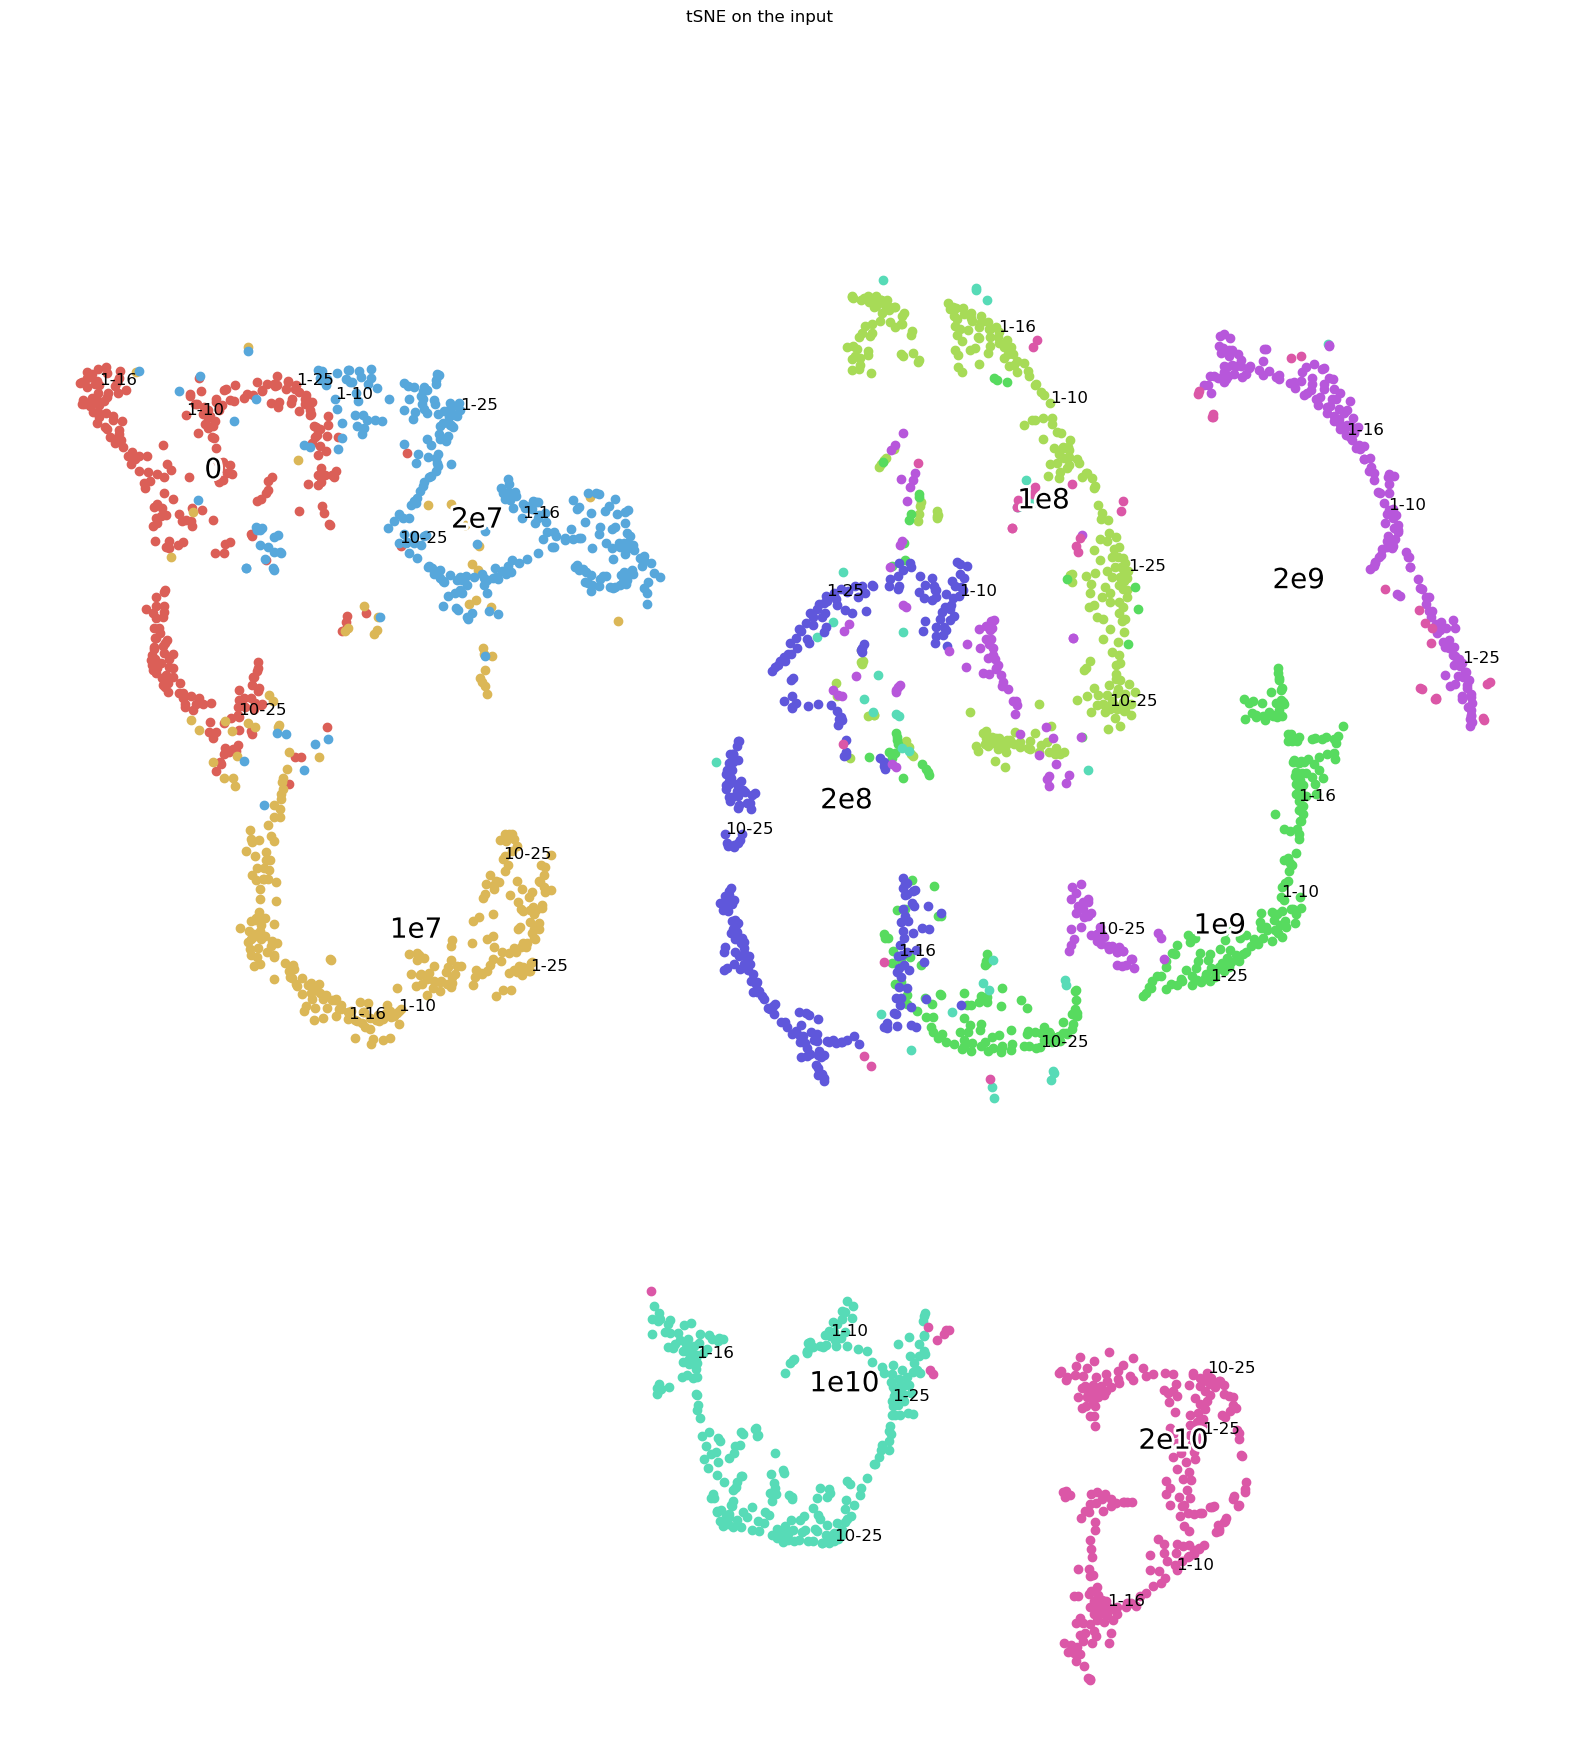

In [32]:
# initializing TSNE for 2 n_components.
tsne = TSNE(n_components=2, random_state=0)
tSNEResult = tsne.fit_transform(arr_transformed)

titleText = "tSNE on the input" 
scatterPlot(tSNEResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\Users\\jc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(-0.5746655512894165, -0.012595210047794188, '0'),
  Text(-0.5625981065616061, -0.028884708338314354, '1e7'),
  Text(0.11400614904238207, -0.0020837210786424014, '1e8'),
  Text(0.2625363393913157, -0.17376856519201117, '1e9'),
  Text(0.528849223762426, -0.05520201767847376, '1e10'),
  Text(-0.5614051719514859, -0.0367161598086818, '2e7'),
  Text(0.05922315998406212, 0.15610002390428407, '2e8'),
  Text(0.14753340158221123, 0.06812613087525475, '2e9'),
  Text(0.7288807605645948, 0.008670964341781596, '2e10')])

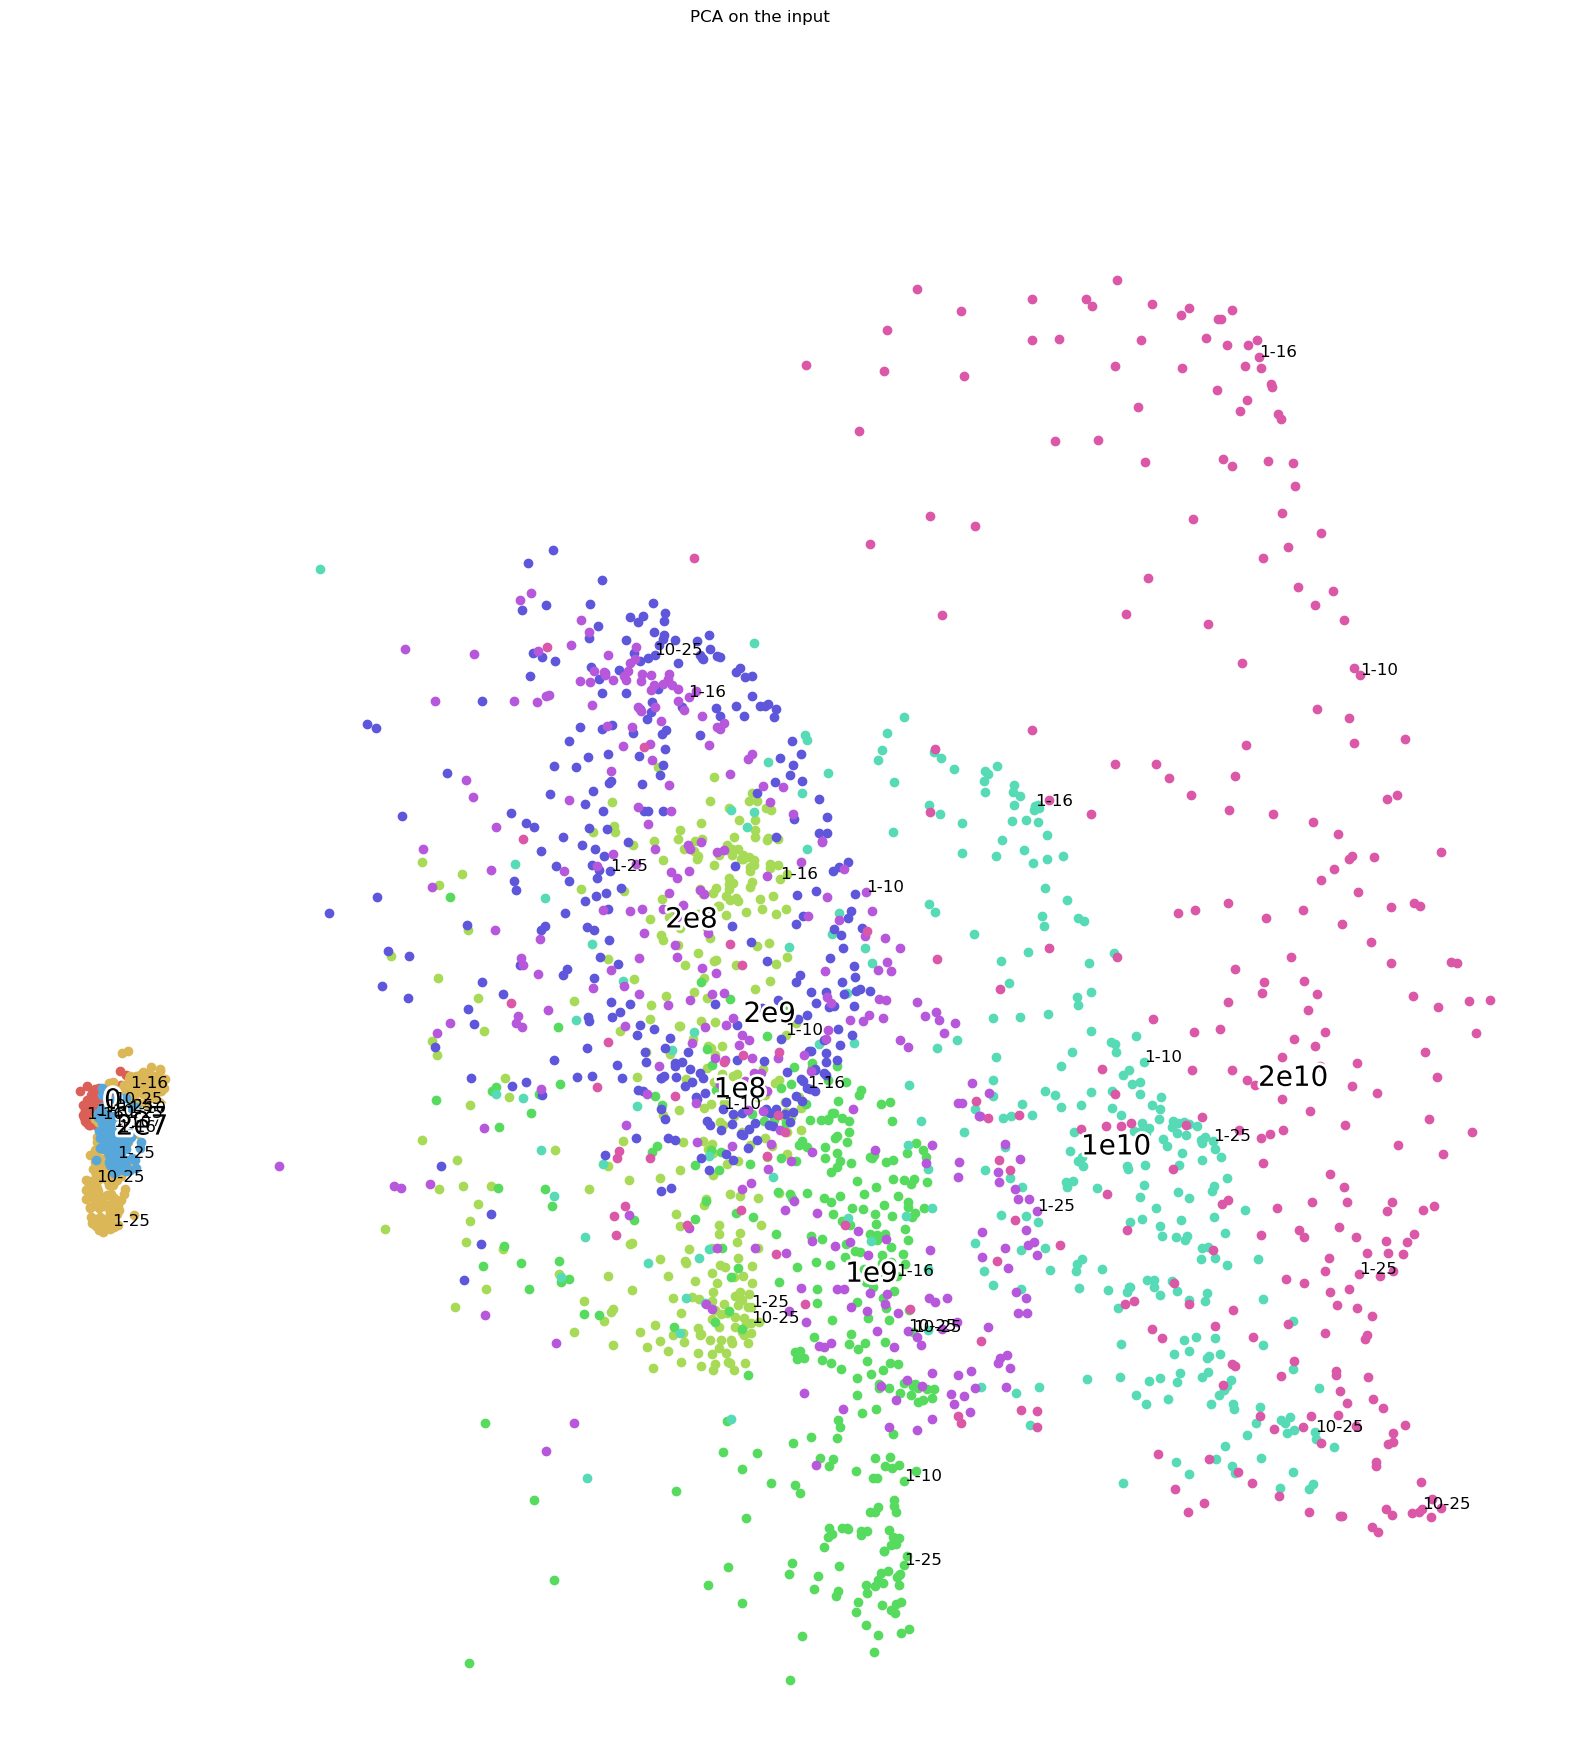

In [33]:
# initializing PCA for 2 n_components.
pca = PCA(n_components=2, random_state=0)
pcaResult = pca.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "PCA on the input"
scatterPlot(pcaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\Users\\jc\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(0.024015991464202933, -0.002369332171164652, '0'),
  Text(0.023311135764569505, -0.003921755905088836, '1e7'),
  Text(-0.004727735641161766, -4.085510672387216e-06, '1e8'),
  Text(-0.011993370395373577, -0.01624294559311435, '1e9'),
  Text(-0.022344153641326088, -0.004185616068011199, '1e10'),
  Text(0.023347818784126003, -0.004658871823128581, '2e7'),
  Text(-0.002196514500433993, 0.014789788631081682, '2e8'),
  Text(-0.005818291861539208, 0.006952869609981635, '2e9'),
  Text(-0.029723960356715703, 0.0024369408112430383, '2e10')])

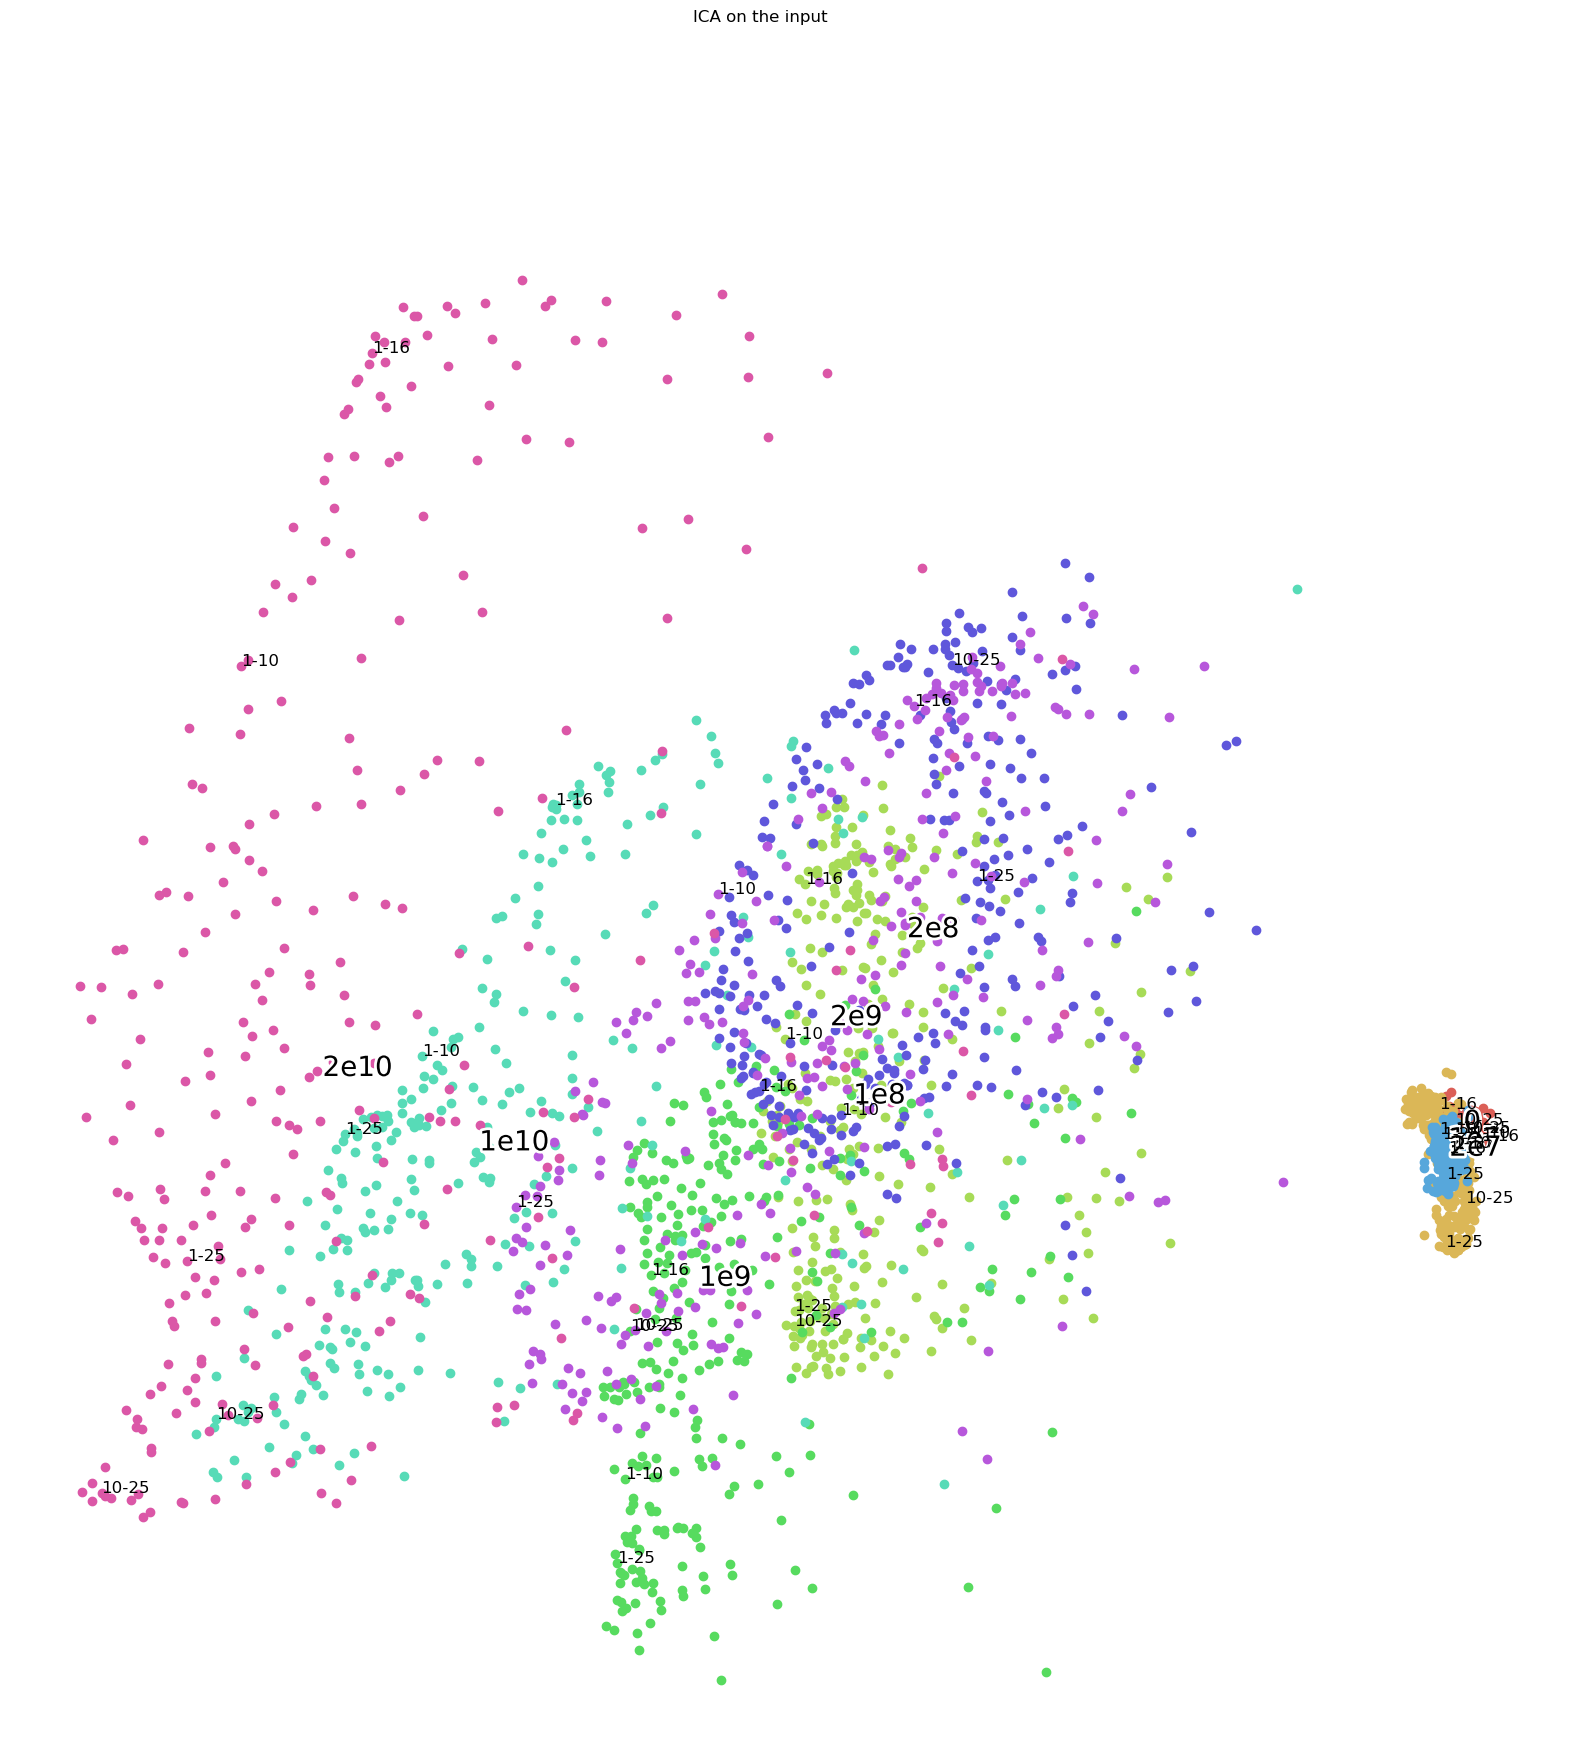

In [34]:
# initializing ICA for 2 n_components.
ICA = FastICA(n_components=2, random_state=0) 
icaResult=ICA.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "ICA on the input"
scatterPlot(icaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

### Clustering results on last 10 files

In [21]:
arr_controlled = average_from_time_series(arr_time_series=arr_time_series, data_limit = 100)

#print_eignvalues_for_a_pair(arr_controlled, ylabel_text, pair_choise = 28)

In [35]:
datasize_pair=300
how_many=5
arr_selected = arr_controlled[0:datasize_pair*how_many, 1:]
ylabel_selected = ylabel[0:datasize_pair*how_many]
ylabel_text_selected = ylabel_text[0:how_many]
pairlabel_selected = pairlabel[0:datasize_pair*how_many]
sc = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#sc = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#sc = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#sc = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
arr_transformed = sc.fit_transform(arr_selected)


In [46]:
pairlabel_selected[7:25]

array([[ 1.,  9.,  2.,  3.],
       [ 1., 10.,  2.,  1.],
       [ 1., 11.,  2.,  1.],
       [ 1., 12.,  2.,  1.],
       [ 1., 13.,  2.,  1.],
       [ 1., 14.,  2.,  1.],
       [ 1., 15.,  2.,  1.],
       [ 1., 16.,  2.,  1.],
       [ 1., 17.,  2.,  2.],
       [ 1., 18.,  2.,  1.],
       [ 1., 19.,  2.,  1.],
       [ 1., 20.,  2.,  1.],
       [ 1., 21.,  2.,  1.],
       [ 1., 22.,  2.,  1.],
       [ 1., 23.,  2.,  1.],
       [ 1., 24.,  2.,  1.],
       [ 1., 25.,  2.,  2.],
       [ 2.,  3.,  1.,  1.]])

In [36]:
# 1-10: parilabel = 8
# 1-16: parilabel = 14
# 1-25: parilabel = 23
# 10-16: parilabel = 185
# 10-25: parilabel = 194
# 16-25: parilabel = 263

# 2-16: parilabel = 37
# 2-15: parilabel = 36
# 2-24: parilabel = 45
# 2-25: parilabel = 46

pairlabel_selected[45:50]

array([[ 2., 24.,  1.,  1.],
       [ 2., 25.,  1.,  2.],
       [ 3.,  4.,  1.,  1.],
       [ 3.,  5.,  1.,  1.],
       [ 3.,  6.,  1.,  1.]])

In [24]:
def get_order_parameter(input_data, ylabel_text, pair_choise = [23]):
    all_order_data= []
    for pair_ in pair_choise:
        test = input_data[[i+pair_ for i in range(0, input_data.shape[0], int(input_data.shape[0]/len(ylabel_text)))]]
        all_order_data.append(test)
    all_order_data = np.array(all_order_data)
    #print(all_order_data)
    #all_order_data = np.sum(all_order_data, axis=0)
    all_order_data = np.average(all_order_data, axis=0)
    #print(all_order_data)
    #print(all_order_data.shape)
    
    return all_order_data

def pretty_pair_labels(labels):
    return [str(int(labels[i][0])) + " - " + str(int(labels[i][1])) for i in range(labels.shape[0])]


In [29]:
arr_selected

array([[ 0.00291516,  0.00151177, -0.00442694,  0.00017531, -0.00043298,
        -0.00186429],
       [ 0.00069981,  0.00167094, -0.00237075, -0.00398895,  0.00069495,
        -0.00458894],
       [ 0.00072671,  0.00264145, -0.00336816, -0.00393222,  0.00141723,
        -0.0069034 ],
       ...,
       [ 0.01146021, -0.03483368,  0.02337347,  0.04598706, -0.01414754,
        -0.01790939],
       [ 0.04913802, -0.0451693 , -0.00396872,  0.05763623,  0.00442535,
        -0.01766841],
       [ 0.04377904, -0.02117015, -0.02260889,  0.0140585 ,  0.01969701,
        -0.00013186]])

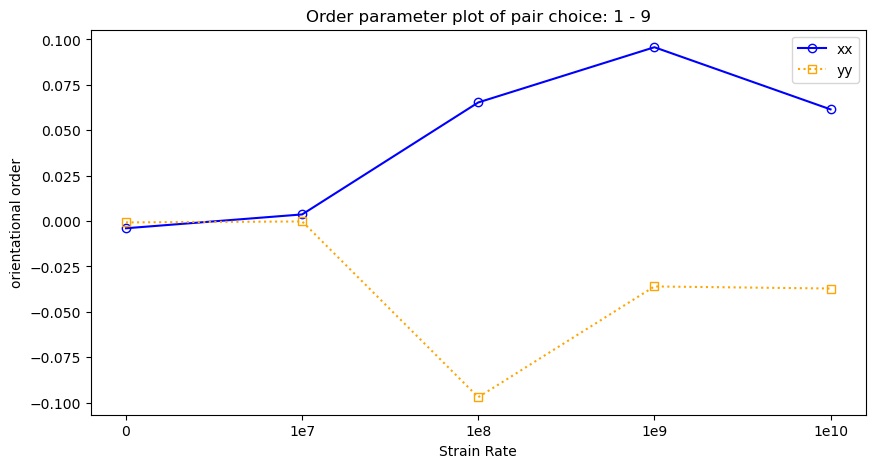

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#pair_choise = [8, 14, 23, 185, 194, 263, 37, 36, 45, 46]
pair_choise = [7]

test = get_order_parameter(arr_selected, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, test.shape[0])]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (9).

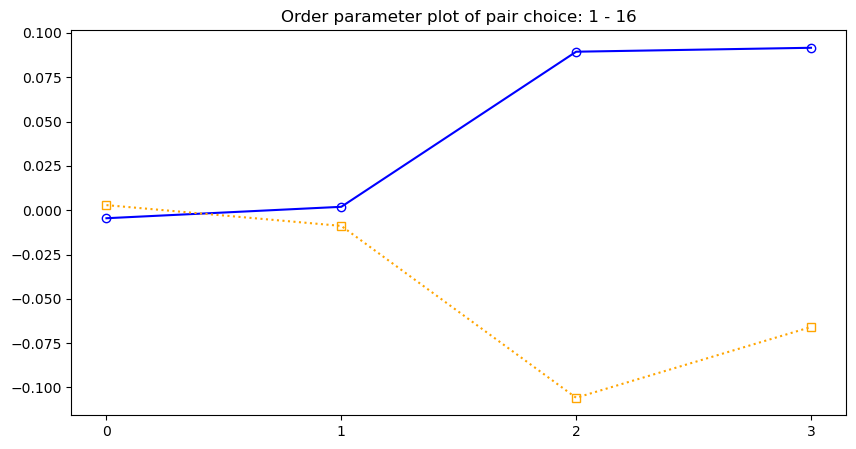

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#pair_choise = [8, 14, 23, 185, 194, 263, 37, 36, 45, 46]
pair_choise = [14]

test = get_order_parameter(arr_selected, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





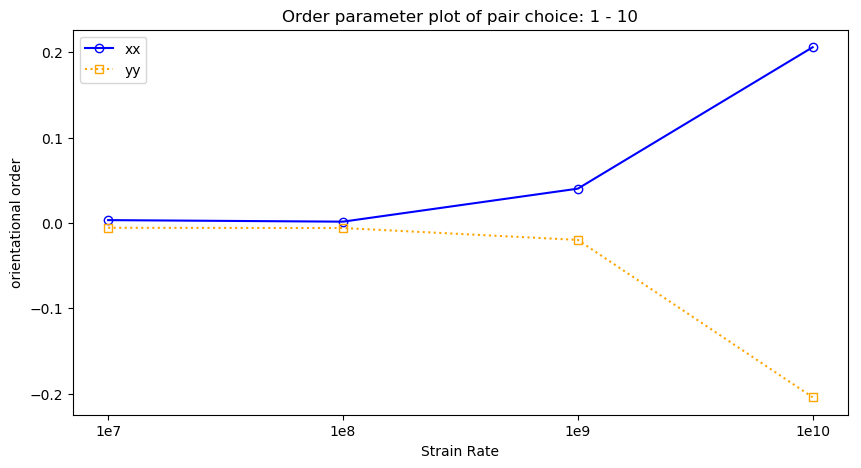

In [200]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#pair_choise = [8, 14, 23, 185, 194, 263, 37, 36, 45, 46]
pair_choise = [8]

test = get_order_parameter(arr_selected, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





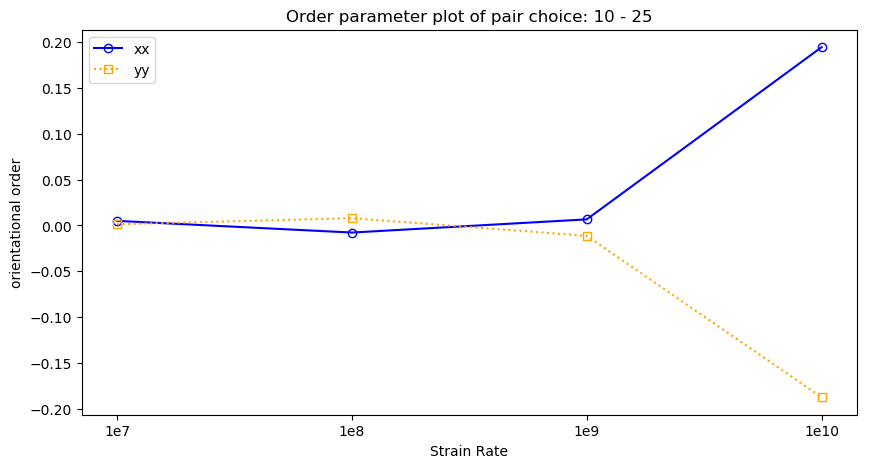

In [199]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#pair_choise = [8, 14, 23, 185, 194, 263, 37, 36, 45, 46]
pair_choise = [194]

test = get_order_parameter(arr_selected, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()

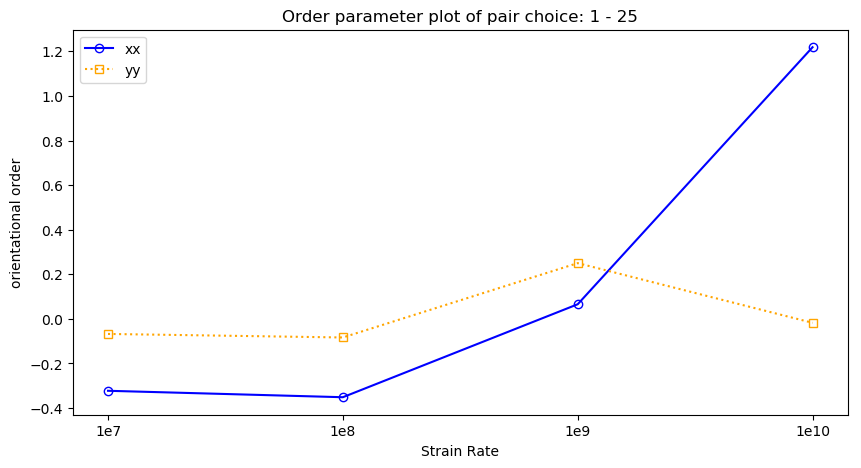

In [198]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#24  1 - 26
#25  1 - 27
#26  1 - 28
#27  1 - 29
#28  1 - 30
#53  2 - 27
#54  2 - 28
#55  2 - 29
#56  2 - 30
#82  3 - 29 
#83  3 - 30
#108 4 - 29  
#109 4 - 30 

#pair_choise = [24,25,26,27,28, 53, 54, 55, 56 , 82, 83, 108, 109]
pair_choise = [23]

test = get_order_parameter(pcaResult, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





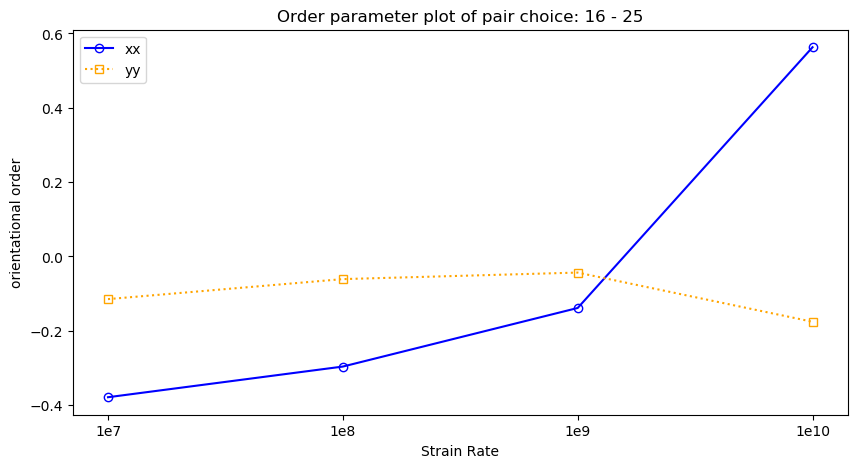

In [197]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
plt.style.use('default')

fig=plt.figure(figsize=(10, 5))


#linestyles = ['-', '--', '-', '--', '-', '--', '-', '--']
linestyles = ['-',':', '--', '-.']

#markerstyles = ["+", "x", "o", "v", "^", "<", ">", "1"]
markerstyles = ["o", "s", "^", "p"]
colors = ['blue', 'orange', 'green', 'red']

#24  1 - 26
#25  1 - 27
#26  1 - 28
#27  1 - 29
#28  1 - 30
#53  2 - 27
#54  2 - 28
#55  2 - 29
#56  2 - 30
#82  3 - 29 
#83  3 - 30
#108 4 - 29  
#109 4 - 30 
    # 1-10: parilabel = 8
    # 1-16: parilabel = 14
    # 1-25: parilabel = 23
    # 10-16: parilabel = 185
    # 10-25: parilabel = 194
    # 16-25: parilabel = 263
#pair_choise = [24,25,26,27,28, 53, 54, 55, 56 , 82, 83, 108, 109]
pair_choise = [263]

test = get_order_parameter(pcaResult, ylabel_text_selected, pair_choise = pair_choise)

#for i in range (len(ylabel_text)):
    
xdata = np.arange(0,test.shape[0],1)
labels = [ylabel_text[i].split('sr')[-1] for i in range(0, len(ylabel_text))]
    
plt.plot(xdata, test[:,0], label='xx', color=colors[0], linestyle=linestyles[0], marker= markerstyles[0], markerfacecolor='none')
plt.plot(xdata, test[:,1], label='yy', color=colors[1], linestyle=linestyles[1], marker= markerstyles[1], markerfacecolor='none')
 


plt.title("Order parameter plot of pair choice: " + str(", ".join(pretty_pair_labels(pairlabel_selected[pair_choise]))))    
#plt.yscale('log')
#plt.ylim(10**-6, 10**0)
#plt.xlim(0, time_limit)
plt.xticks(xdata, labels)
plt.xlabel('Strain Rate')
plt.ylabel('orientational order')
plt.legend()
plt.show()





(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(32.1321,-10.7153,'1e7'),
  Text(8.49289,-12.5971,'1e8'),
  Text(-32.9721,-0.365952,'1e9'),
  Text(-8.90825,33.9286,'1e10')])

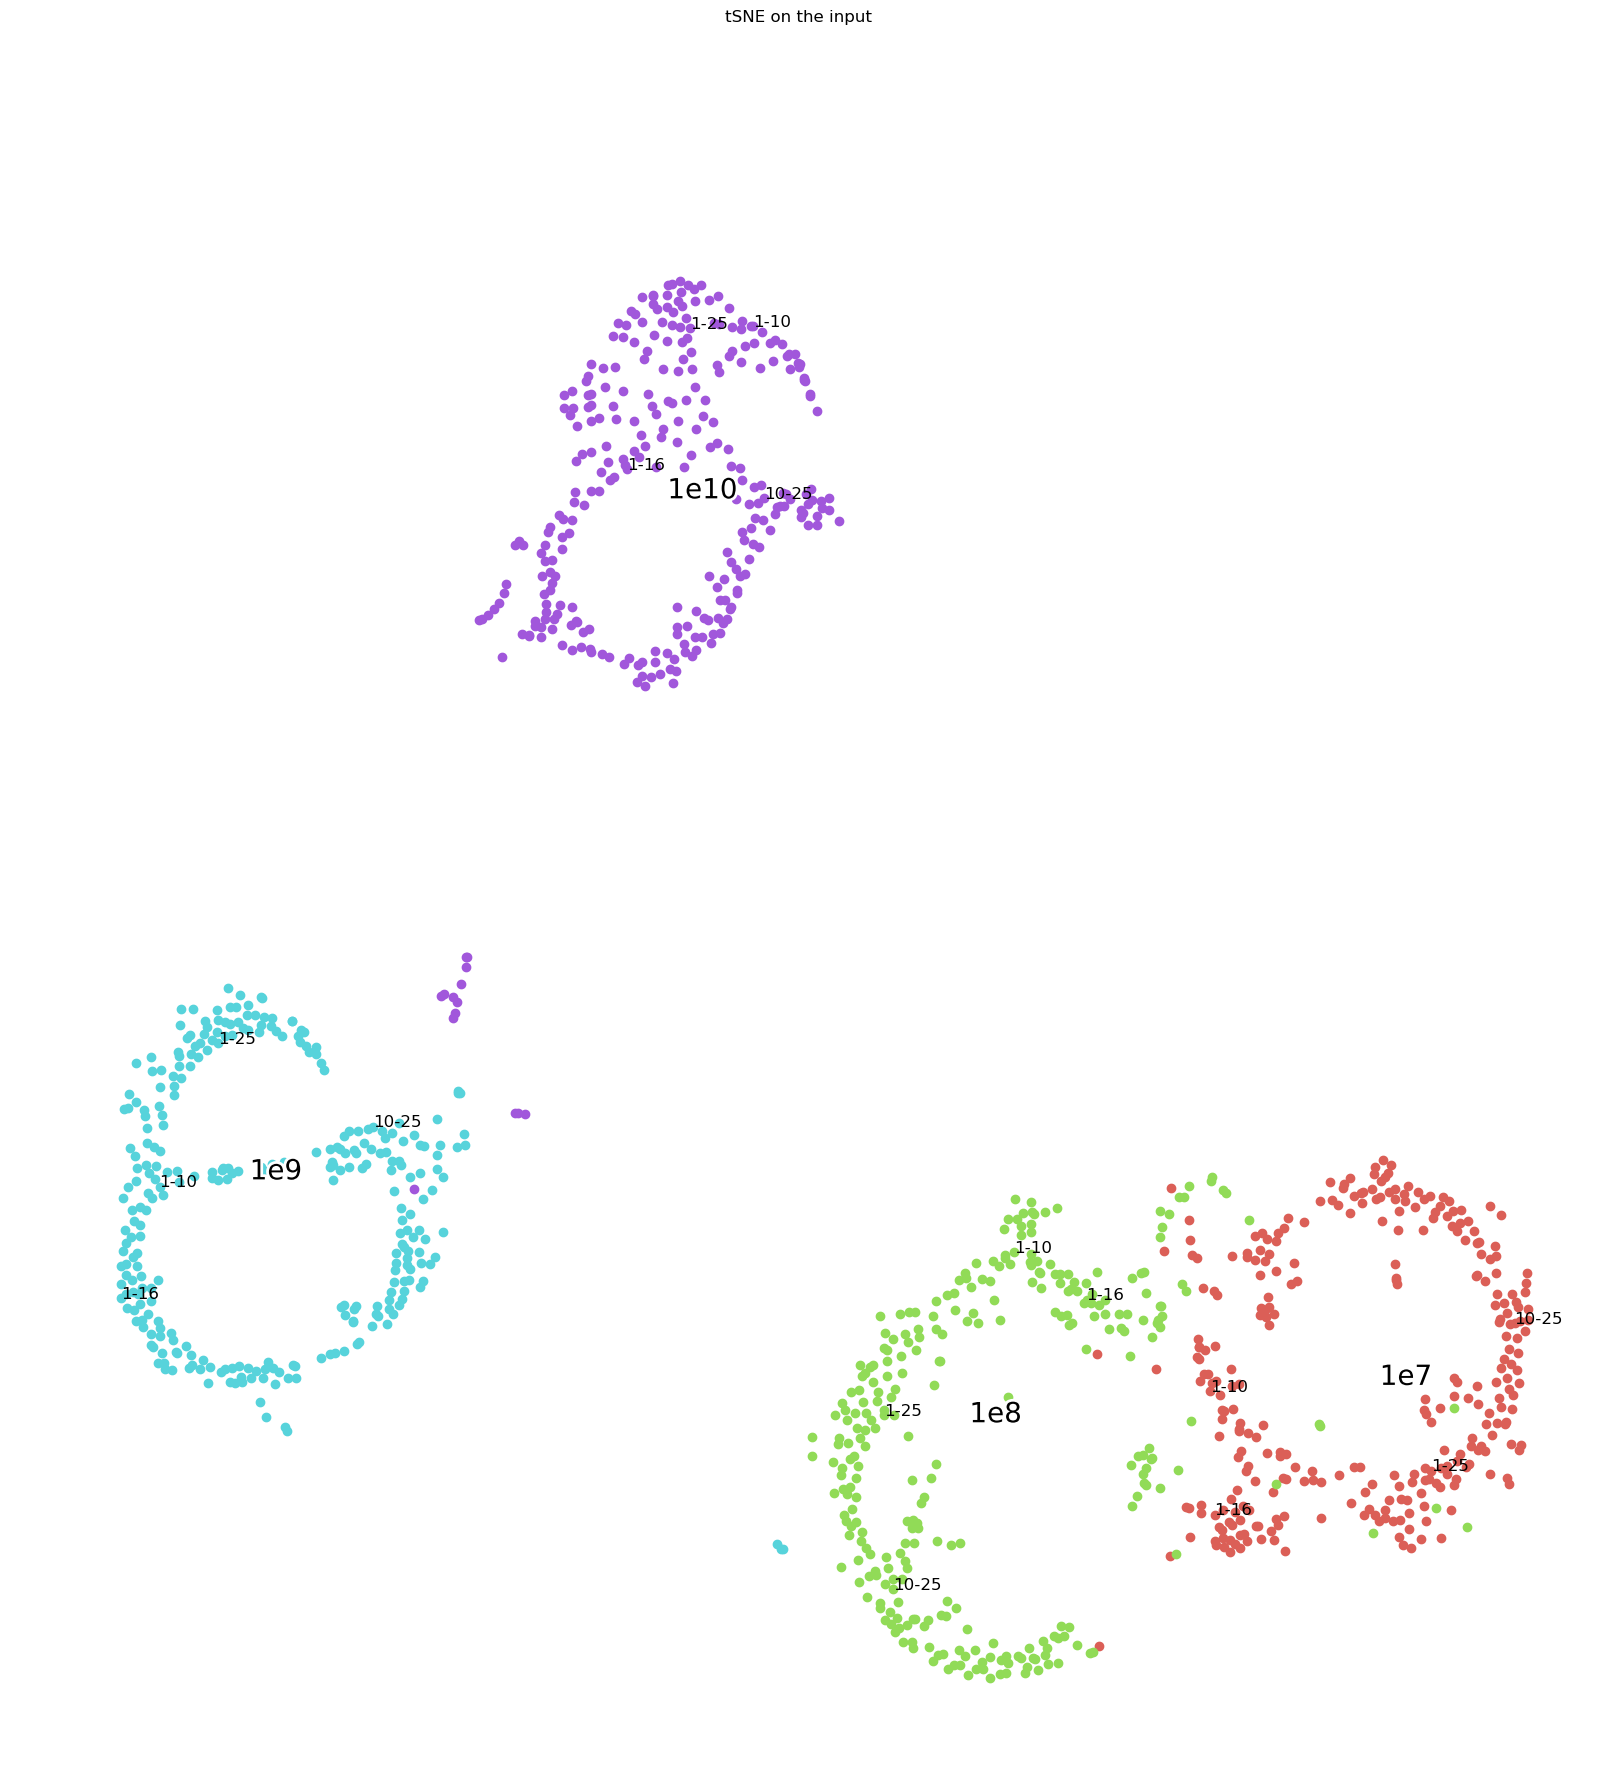

In [196]:
# initializing TSNE for 2 n_components.
tsne = TSNE(n_components=2, random_state=0, perplexity=45, n_iter=2000)
tSNEResult = tsne.fit_transform(arr_transformed)

titleText = "tSNE on the input" 
scatterPlot(tSNEResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

In [145]:
print(pca.components_)
print(pca.explained_variance_)
print(np.sum(pca.components_[0]*pca.components_[0]))

[[ 0.48352639 -0.54606461  0.10543293  0.61822431 -0.0335363  -0.27124449]
 [ 0.02679184  0.34505169 -0.80643568  0.45022334 -0.14222782  0.08338594]]
[0.2244902  0.04033659]
0.9999999999999998


(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(-0.332069,-0.104696,'1e7'),
  Text(-0.315355,-0.0923581,'1e8'),
  Text(-0.0601116,0.231616,'1e9'),
  Text(0.776144,-0.0756588,'1e10')])

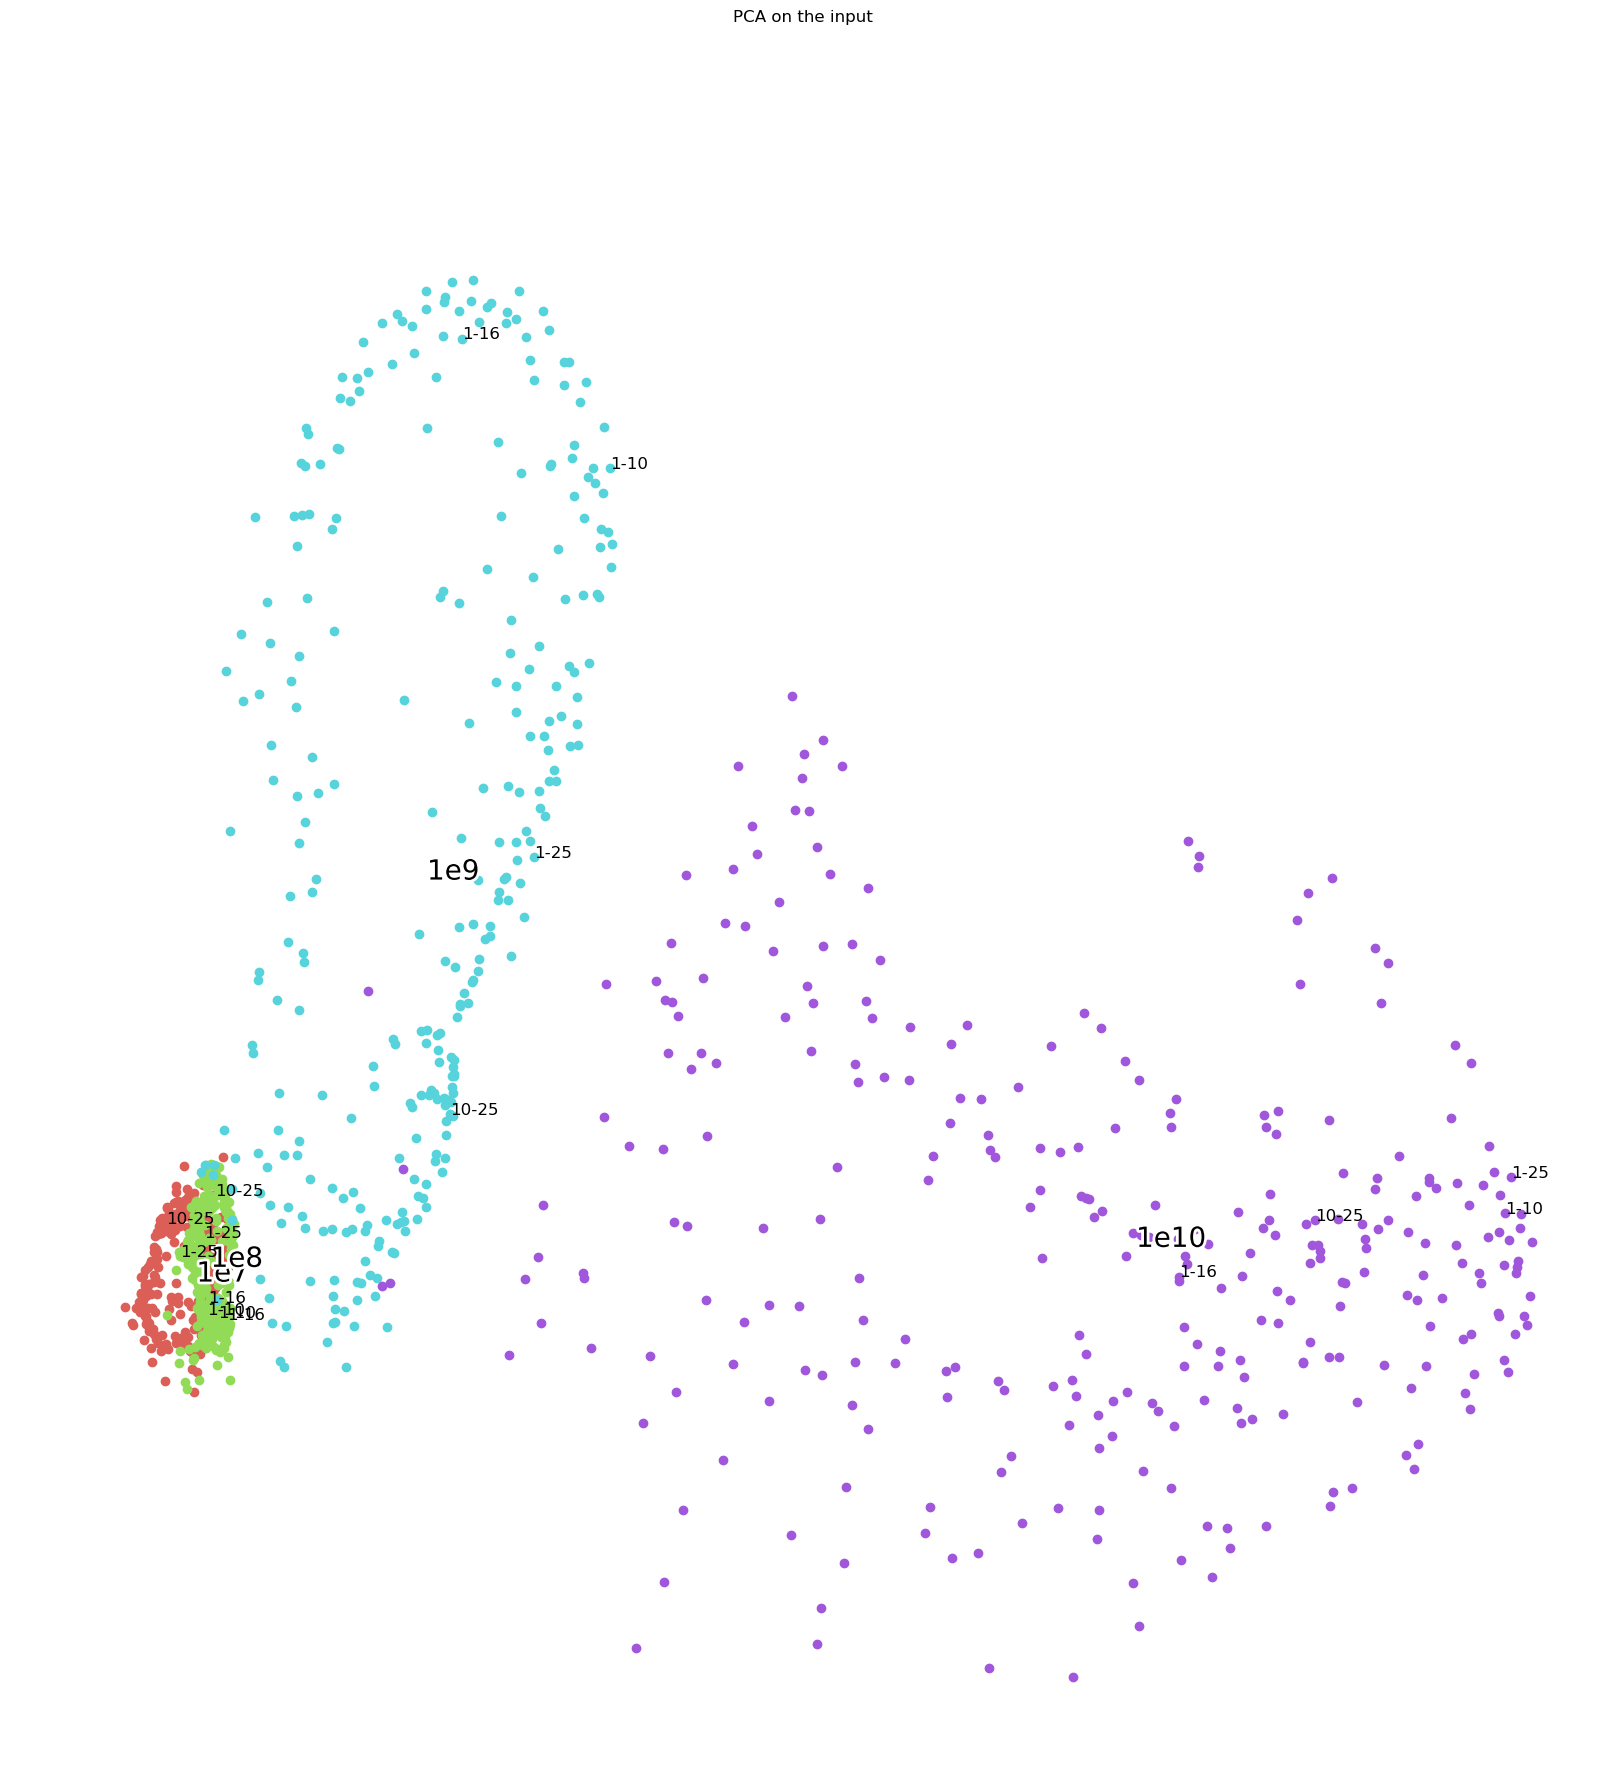

In [194]:
# initializing PCA for 2 n_components.
pca = PCA(n_components=2, random_state=0)
pcaResult = pca.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "PCA on the input"
scatterPlot(pcaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)

(<Figure size 2000x2000 with 1 Axes>,
 <module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>,
 [Text(0.0241726,-0.00230823,'1e7'),
  Text(0.0238107,-0.00132152,'1e8'),
  Text(-0.0103119,0.0271796,'1e9'),
  Text(-0.0369099,-0.0347651,'1e10')])

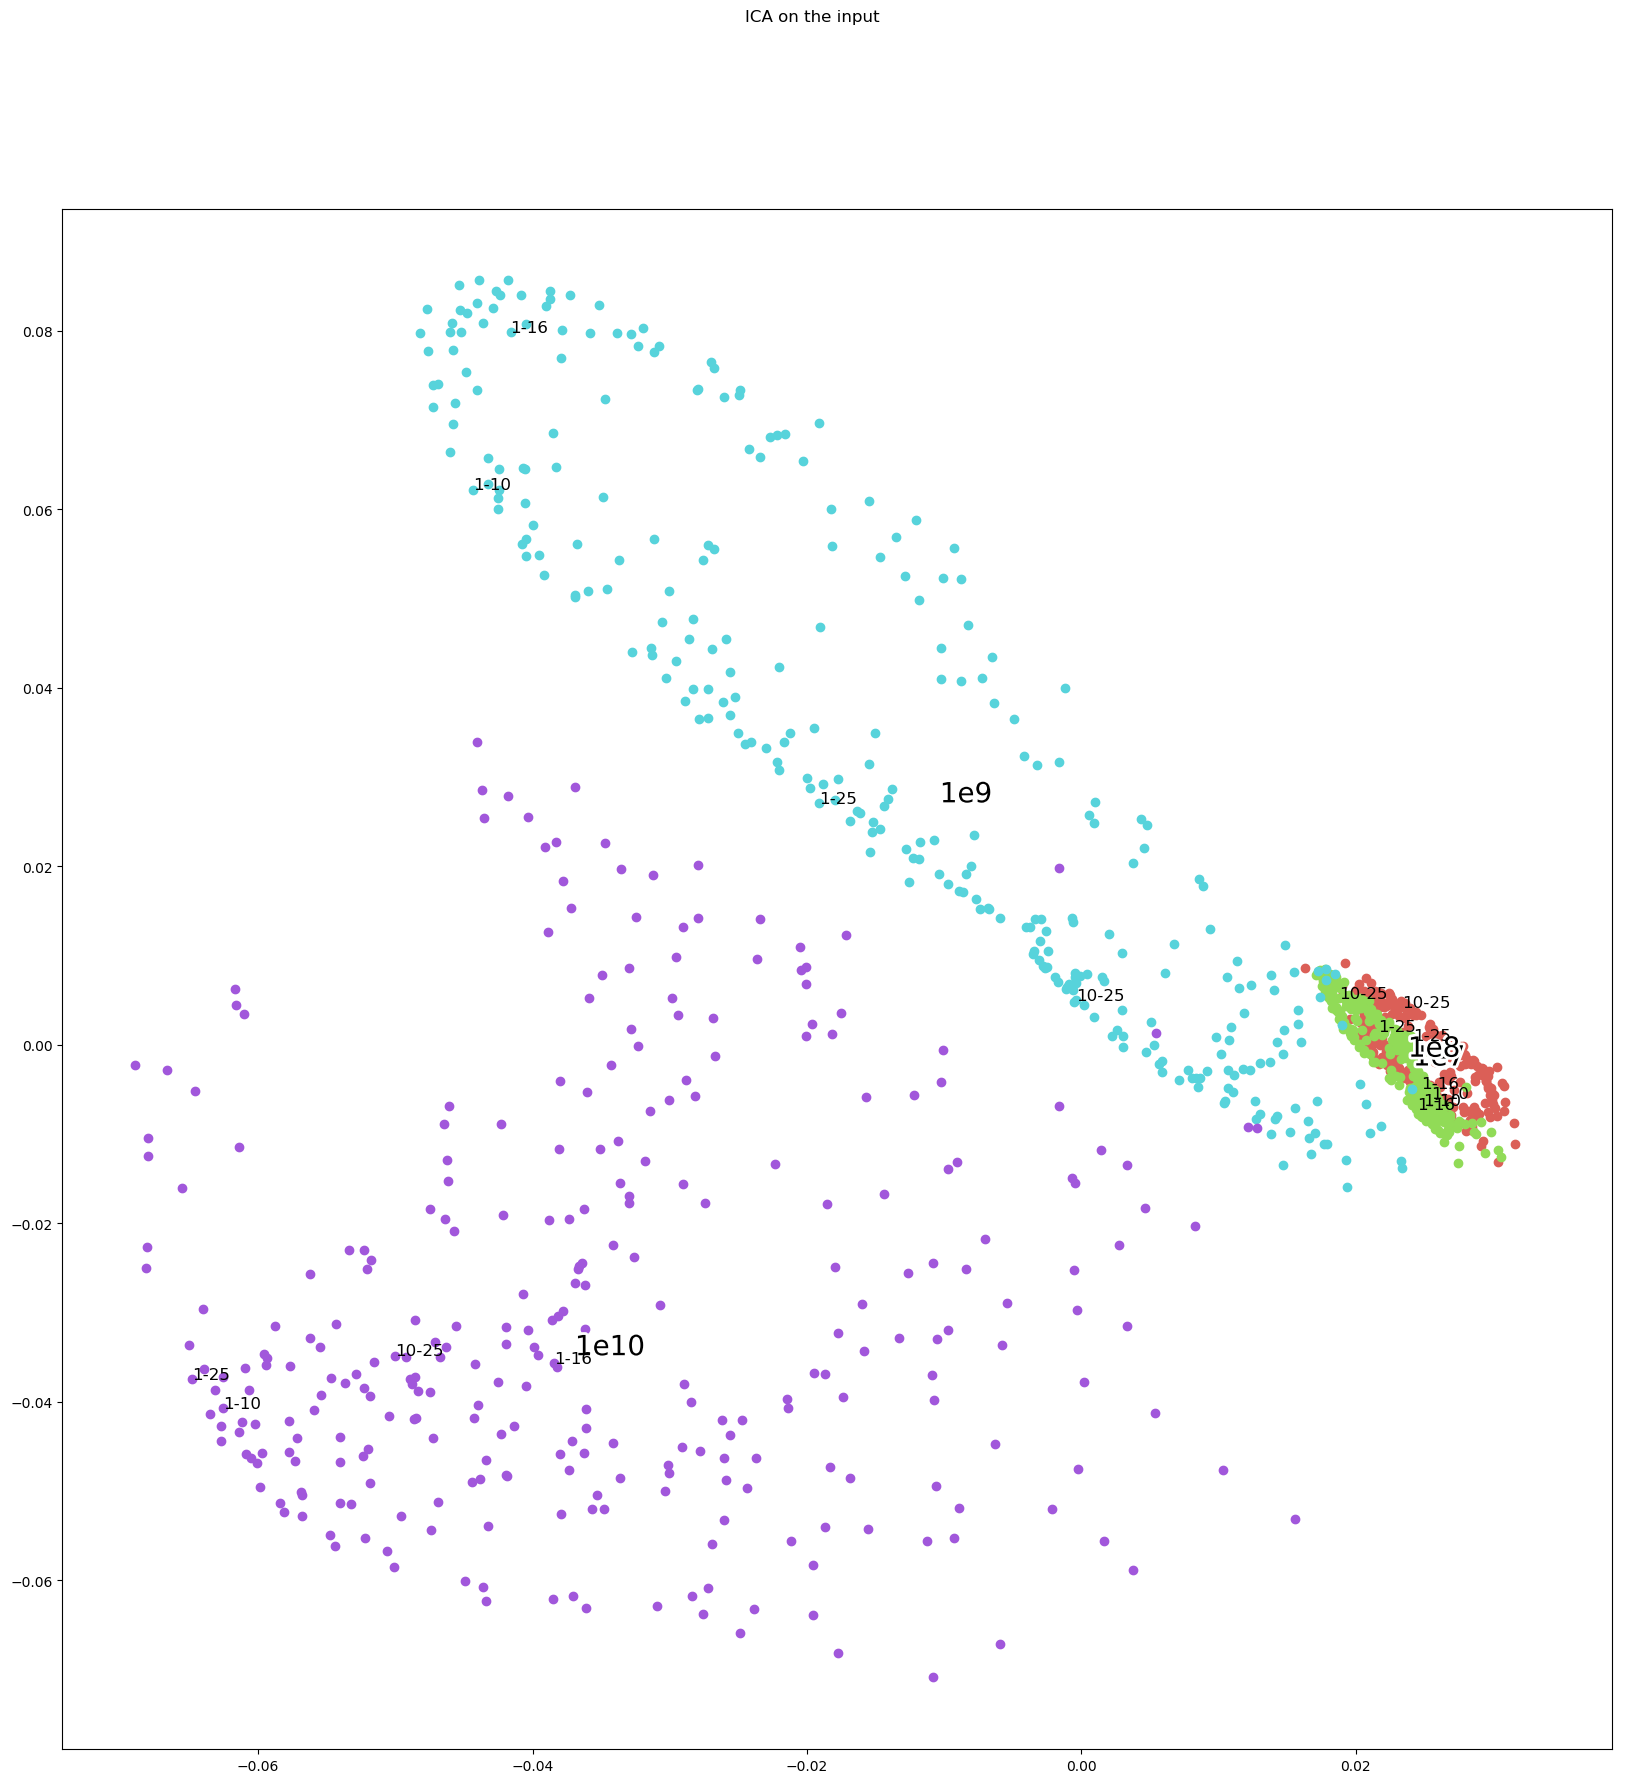

In [155]:
# initializing ICA for 2 n_components.
ICA = FastICA(n_components=2, random_state=0) 
icaResult=ICA.fit_transform(arr_transformed)

# Visualizing the PCA output
titleText = "ICA on the input"
scatterPlot(icaResult, ylabel_selected, ylabel_text_selected, pairlabel_selected, titleText)